### Загрузка библиотек

In [1]:
!pip install arch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error as mape
from math import sqrt
import datetime as dt

### Загрузка данных

In [3]:
data = pd.read_excel('RC_F01_01_2016_T01_01_2022.xlsx', parse_dates = ['data'])
data = data.drop(['nominal', 'cdx'], axis=1)
data = data.rename(columns={'curs': 'Курс', 'data': 'Дата'})
#data['Дата'] = pd.to_datetime(data['Дата'])
data['Дата'] = data['Дата'].dt.strftime('%Y-%m')

C:\ProgramData\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
data_new = data.groupby('Дата').mean()
data_new = data_new.reset_index()

In [5]:
ydata = pd.read_csv('USDRUB_230101_231231.csv', sep=';', parse_dates=['<DATE>'], dayfirst=True)
ydata = ydata.drop(['<VOL>', '<LOW>', '<HIGH>', '<OPEN>', '<TIME>'], axis=1)
ydata = ydata.rename(columns={'<CLOSE>': 'Курс', '<DATE>': 'Дата'})

### График динамики

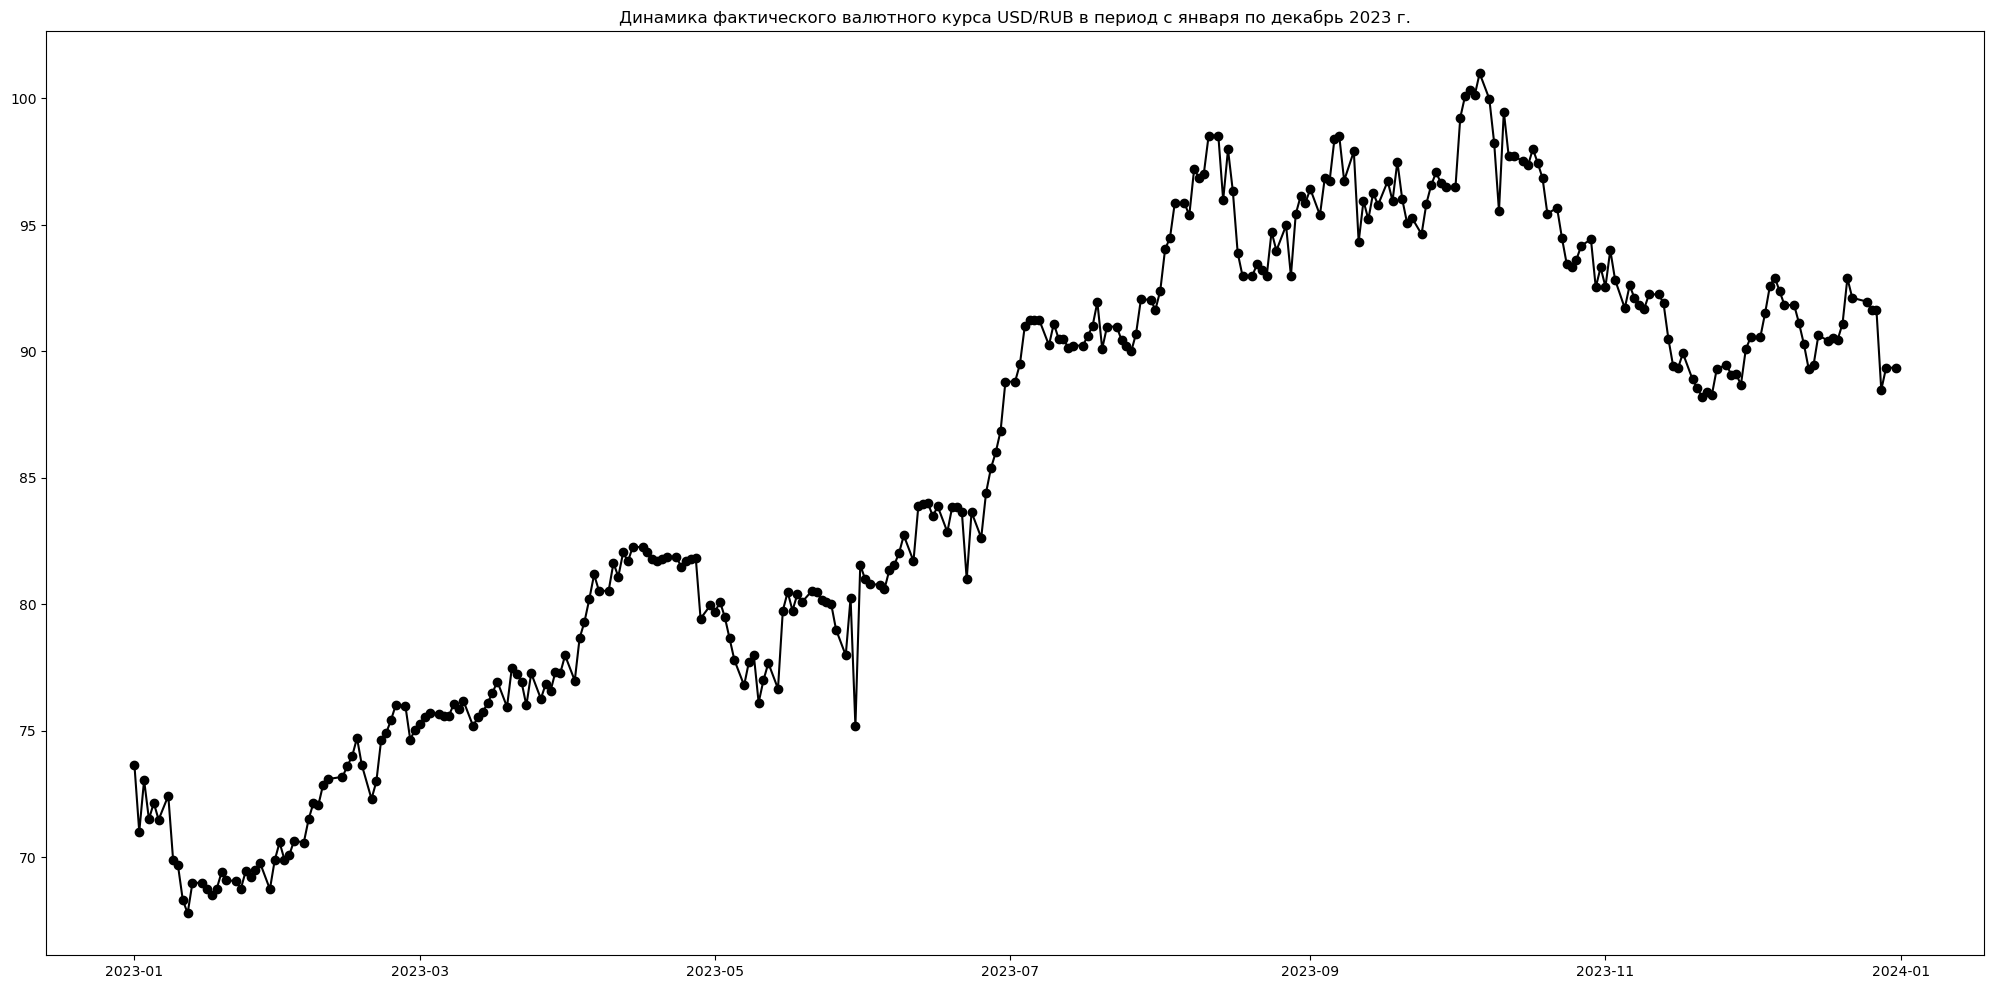

In [6]:
plt.figure(figsize=(25, 12))
plt.plot(ydata['Дата'], ydata['Курс'], color='black', marker='o')
plt.title('Динамика фактического валютного курса USD/RUB в период с января по декабрь 2023 г.')
plt.xticks()
plt.show()

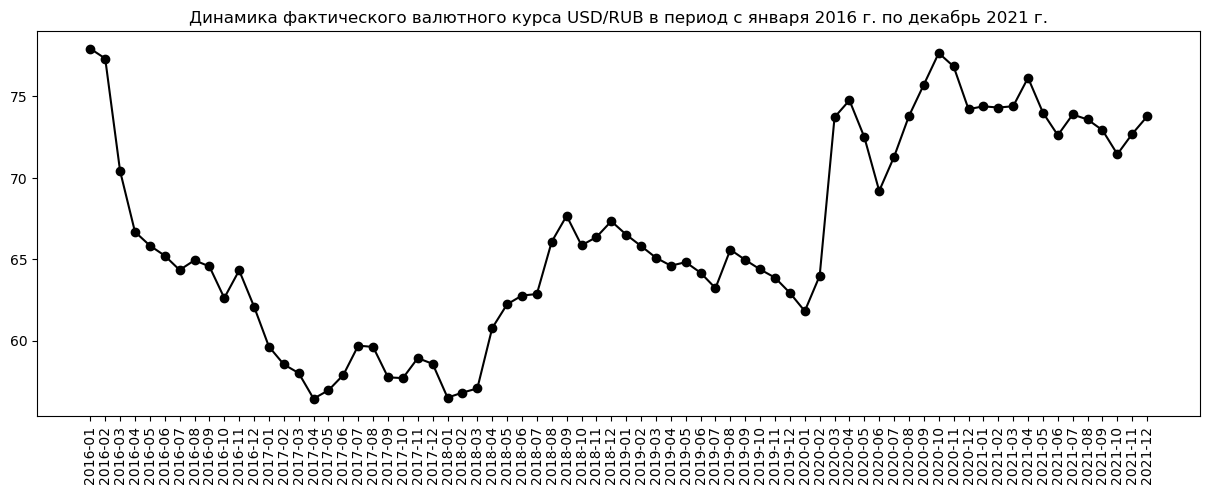

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(data_new['Дата'], data_new['Курс'], color='black', marker='o')
plt.title('Динамика фактического валютного курса USD/RUB в период с января 2016 г. по декабрь 2021 г.')
plt.xticks(rotation='vertical')
plt.show()

### Анализ динамики

In [8]:
ymax = ydata['Курс'].max()
nmax = data_new['Курс'].max()

ymin = ydata['Курс'].min()
nmin = data_new['Курс'].min()

In [9]:
ydata.loc[ydata['Курс'] == ymax]

,Дата,Курс
238,2023-10-06,100.992


In [10]:
ydata.loc[ydata['Курс'] == ymin]

,Дата,Курс
10,2023-01-12,67.7804


In [11]:
data_new.loc[data_new['Курс'] == nmax]

,Дата,Курс
0,2016-01,77.934425


In [12]:
data_new.loc[data_new['Курс'] == nmin]

,Дата,Курс
15,2017-04,56.435614


### Тренд, сезонность, остатки для 2016-2022

In [13]:
data_new.set_index('Дата', inplace=True)

<Figure size 1000x1000 with 0 Axes>

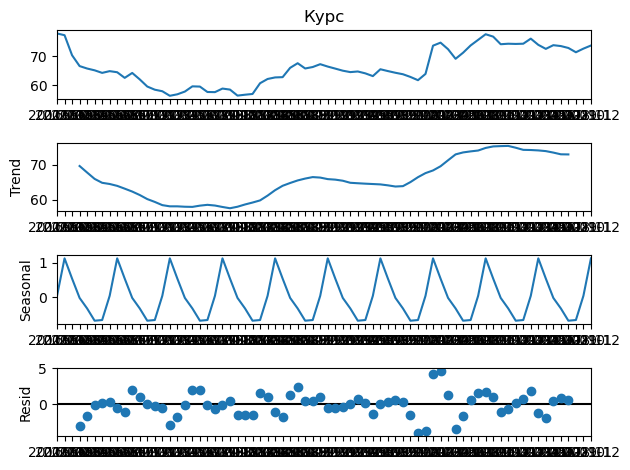

{'trend': Дата
 2016-04    69.679967
 2016-05    67.823124
 2016-06    65.998654
 2016-07    64.884609
 2016-08    64.546195
              ...    
 2021-05    74.135948
 2021-06    73.937291
 2021-07    73.516285
 2021-08    73.024139
 2021-09    72.990573
 Name: trend, Length: 66, dtype: float64,
 'seasonal': Дата
 2016-01    0.037917
 2016-02    1.125372
 2016-03    0.538573
 2016-04   -0.023345
 2016-05   -0.328615
              ...   
 2021-08   -0.328615
 2021-09   -0.684693
 2021-10   -0.665209
 2021-11    0.037917
 2021-12    1.125372
 Name: seasonal, Length: 72, dtype: float64,
 'resid': Дата
 2016-04   -2.973985
 2016-05   -1.655853
 2016-06   -0.094694
 2016-07    0.118568
 2016-08    0.352415
              ...   
 2021-05   -1.257047
 2021-06   -1.859007
 2021-07    0.396952
 2021-08    0.887209
 2021-09    0.620338
 Name: resid, Length: 66, dtype: float64}

In [14]:
decomposition = seasonal_decompose(data_new['Курс'], 
                                   model='additive', 
                                   period=7)  

plt.figure(figsize=(10,10))
decomposition_plot = decomposition.plot()
plt.tight_layout()
plt.xticks()
plt.show()

decomposed_components = {
    'trend': decomposition.trend.dropna(),
    'seasonal': decomposition.seasonal.dropna(),
    'resid': decomposition.resid.dropna()
}
decomposed_components

<Figure size 1200x600 with 0 Axes>

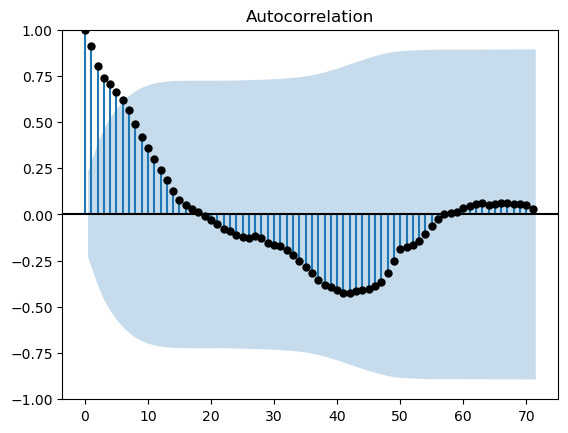

In [15]:
plt.figure(figsize=(12, 6))
plot_acf(data_new['Курс'], lags=71, color='black')
plt.show()

### Тренд, сезонность, остатки для 2023

In [16]:
ydata.set_index('Дата', inplace=True)

<Figure size 1000x1000 with 0 Axes>

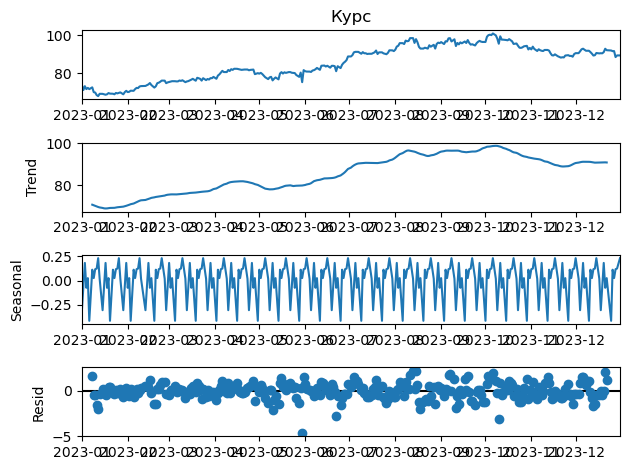

{'trend': Дата
 2023-01-08    70.628842
 2023-01-09    70.340629
 2023-01-10    70.058271
 2023-01-11    69.754638
 2023-01-12    69.525192
                 ...    
 2023-12-18    90.876817
 2023-12-19    90.954350
 2023-12-20    90.976079
 2023-12-21    90.937200
 2023-12-22    90.879950
 Name: trend, Length: 299, dtype: float64,
 'seasonal': Дата
 2023-01-01   -0.303297
 2023-01-02   -0.056070
 2023-01-03    0.182806
 2023-01-04   -0.072971
 2023-01-05    0.026369
                 ...   
 2023-12-26    0.113033
 2023-12-27    0.026871
 2023-12-28    0.118293
 2023-12-29    0.124971
 2023-12-31    0.231935
 Name: seasonal, Length: 311, dtype: float64,
 'resid': Дата
 2023-01-08    1.687125
 2023-01-09   -0.487500
 2023-01-10   -0.502964
 2023-01-11   -1.577109
 2023-01-12   -1.976727
                 ...   
 2023-12-18   -0.053120
 2023-12-19   -0.432980
 2023-12-20   -0.062086
 2023-12-21    2.028171
 2023-12-22    1.208381
 Name: resid, Length: 299, dtype: float64}

In [17]:
decomposition = seasonal_decompose(ydata['Курс'], 
                                   model='additive', 
                                   period=12)  

plt.figure(figsize=(10,10))
decomposition_plot = decomposition.plot()
plt.tight_layout()
plt.show()

decomposed_components = {
    'trend': decomposition.trend.dropna(),
    'seasonal': decomposition.seasonal.dropna(),
    'resid': decomposition.resid.dropna()
}
decomposed_components

<Figure size 1200x600 with 0 Axes>

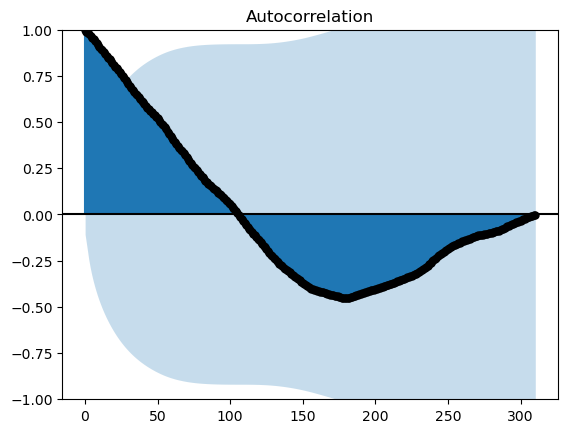

In [18]:
plt.figure(figsize=(12, 6))
plot_acf(ydata['Курс'], lags=310, color='black')
plt.show()

### Проверка на стационарность 2016-2022

In [19]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

stationarity_test = test_stationarity(data_new['Курс'])
stationarity_test

Test Statistic                 -1.111668
p-value                         0.710397
#Lags Used                      2.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

### Проверка на стационарность 2023

In [20]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

stationarity_test = test_stationarity(ydata['Курс'])
stationarity_test

Test Statistic                  -1.435923
p-value                          0.564938
#Lags Used                       1.000000
Number of Observations Used    309.000000
Critical Value (1%)             -3.451691
Critical Value (5%)             -2.870939
Critical Value (10%)            -2.571778
dtype: float64

### Дифференцирование 2016-2021

In [21]:
data_diff = data_new['Курс'].diff().dropna()

In [22]:
result = adfuller(data_diff)
print('Test Statistic: %f' % result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistic: -7.113452
p-value:  3.8851694528798914e-10
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


<Axes: xlabel='Дата'>

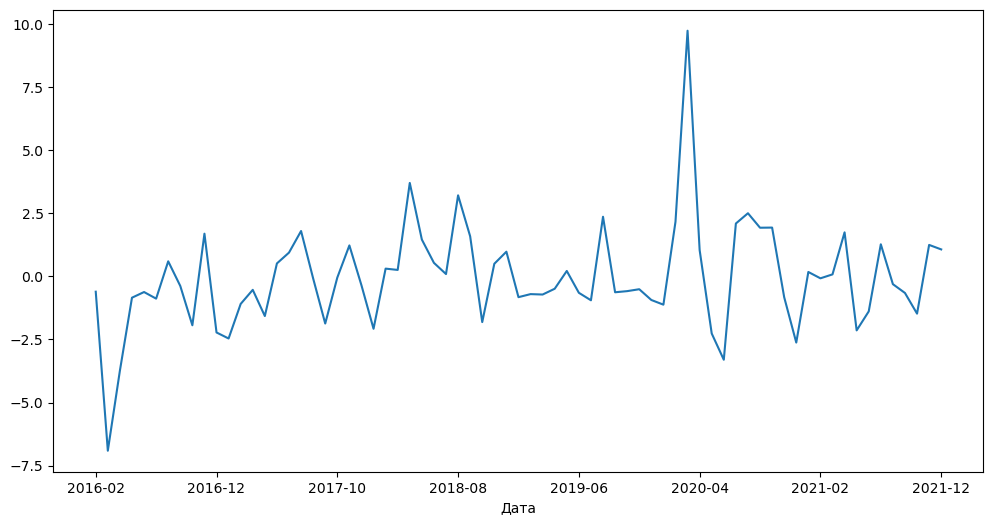

In [23]:
plt.figure(figsize=(12, 6))
data_diff.plot()

<Figure size 1200x600 with 0 Axes>

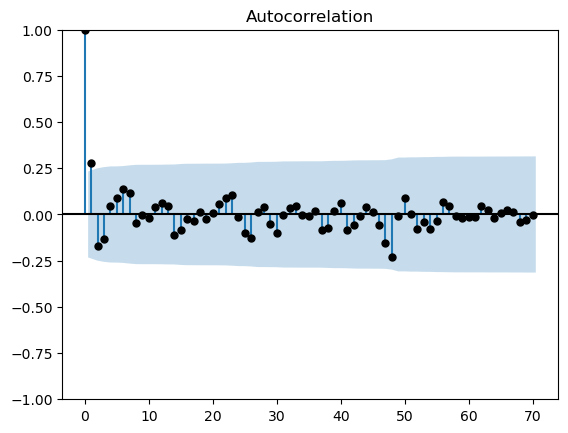

In [24]:
plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=70, color='black')
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

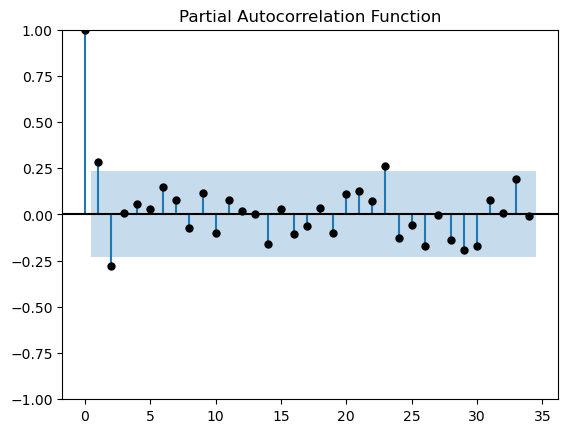

In [25]:
plt.figure(figsize=(12, 6))
plot_pacf(data_diff, lags=34, color='black')
plt.title('Partial Autocorrelation Function')
plt.show()

### Дифференцирование 2023

In [26]:
ydata_diff = ydata['Курс'].diff().dropna()

In [27]:
result = adfuller(ydata_diff)
print('Test Statistic: %f' % result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistic: -25.039029
p-value: 0.0
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


<Axes: xlabel='Дата'>

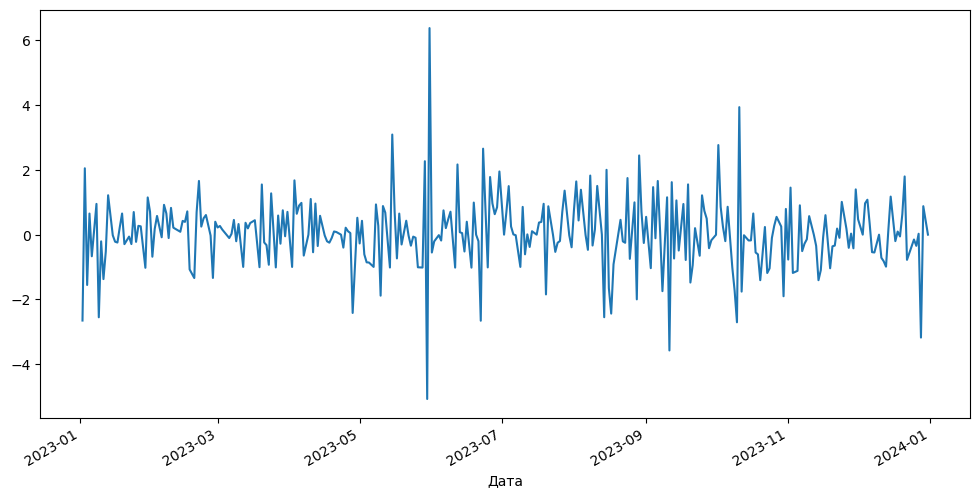

In [28]:
plt.figure(figsize=(12, 6))
ydata_diff.plot()

<Figure size 1200x600 with 0 Axes>

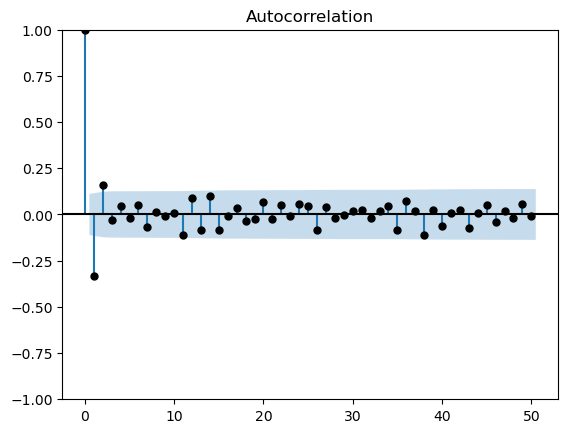

In [29]:
plt.figure(figsize=(12, 6))
plot_acf(ydata_diff, lags=50, color='black')
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

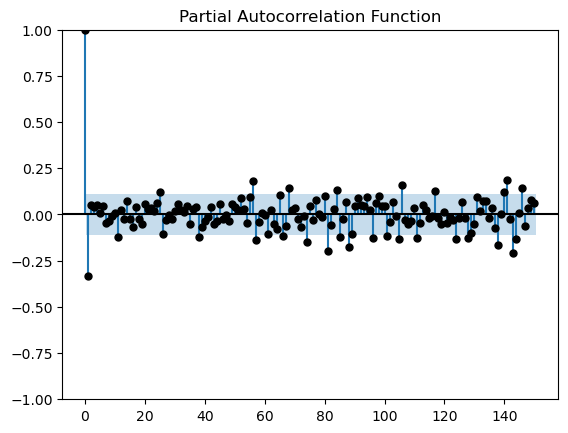

In [30]:
plt.figure(figsize=(12, 6))
plot_pacf(ydata_diff, lags=150, color='black')
plt.title('Partial Autocorrelation Function')
plt.show()

### ARIMA 2023

In [31]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [32]:
p = range(2, 10)
d = range(1, 2)
q = range(2, 10)

min_aic = np.inf
for i in p:
    for j in d:
        for k in q:
                model = ARIMA(ydata['Курс'], order=(i, j, k)).fit()
                aic = model.aic
                if aic < min_aic:
                    min_aic = aic
                    best_arima = (i, j, k)

print('Оптимальные параметры модели ARIMA:')
print('p:', best_arima[0])
print('d:', best_arima[1])
print('q:', best_arima[2])

Оптимальные параметры модели ARIMA:
p: 3
d: 1
q: 2


In [33]:
results_dict = {}

p_range = range(0, 10)
d_range = range(1, 2)
q_range = range(0, 10)

for p in p_range:
    for d in d_range:
        for q in q_range:
            
            model = ARIMA(ydata['Курс'], order=(p, d, q))
            
            res = model.fit()
            
            predictions = res.forecast()
            
            aic = res.aic
            bic = res.bic

            results_dict[(p, d, q)] = {'aic': aic, 'bic': bic}

sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1]['aic']))

for (p, d, q), result in sorted_results.items():
    print(f'p={p}, d={d}, q={q}: {result}')

p=1, d=1, q=0: {'aic': 912.1036981580453, 'bic': 919.5768427530037}
p=0, d=1, q=2: {'aic': 912.4231238184028, 'bic': 923.6328407108404}
p=2, d=1, q=0: {'aic': 913.0003701376836, 'bic': 924.2100870301211}
p=1, d=1, q=1: {'aic': 913.2128612389688, 'bic': 924.4225781314063}
p=2, d=1, q=1: {'aic': 913.784287846971, 'bic': 928.7305770368878}
p=3, d=1, q=2: {'aic': 914.0988430691247, 'bic': 936.5182768539999}
p=3, d=1, q=0: {'aic': 914.3949835487024, 'bic': 929.3412727386192}
p=1, d=1, q=2: {'aic': 914.4208184004519, 'bic': 929.3671075903687}
p=0, d=1, q=3: {'aic': 914.4226024785523, 'bic': 929.3688916684691}
p=6, d=1, q=3: {'aic': 914.5175985192585, 'bic': 951.8833214940504}
p=6, d=1, q=2: {'aic': 914.5634696766301, 'bic': 948.1926203539429}
p=1, d=1, q=3: {'aic': 914.5994230010513, 'bic': 933.2822844884472}
p=3, d=1, q=6: {'aic': 915.1657419004177, 'bic': 952.5314648752096}
p=0, d=1, q=4: {'aic': 915.3626285366134, 'bic': 934.0454900240094}
p=4, d=1, q=0: {'aic': 915.497913351931, 'bic': 9

In [34]:
model = ARIMA(ydata, order=(2,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Курс   No. Observations:                  311
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -452.892
Date:                Wed, 15 May 2024   AIC                            913.784
Time:                        17:08:46   BIC                            928.731
Sample:                             0   HQIC                           919.759
                                - 311                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2931      0.390      0.752      0.452      -0.471       1.057
ar.L2          0.2718      0.122      2.226      0.026       0.032       0.511
ma.L1         -0.6099      0.393     -1.552      0.1

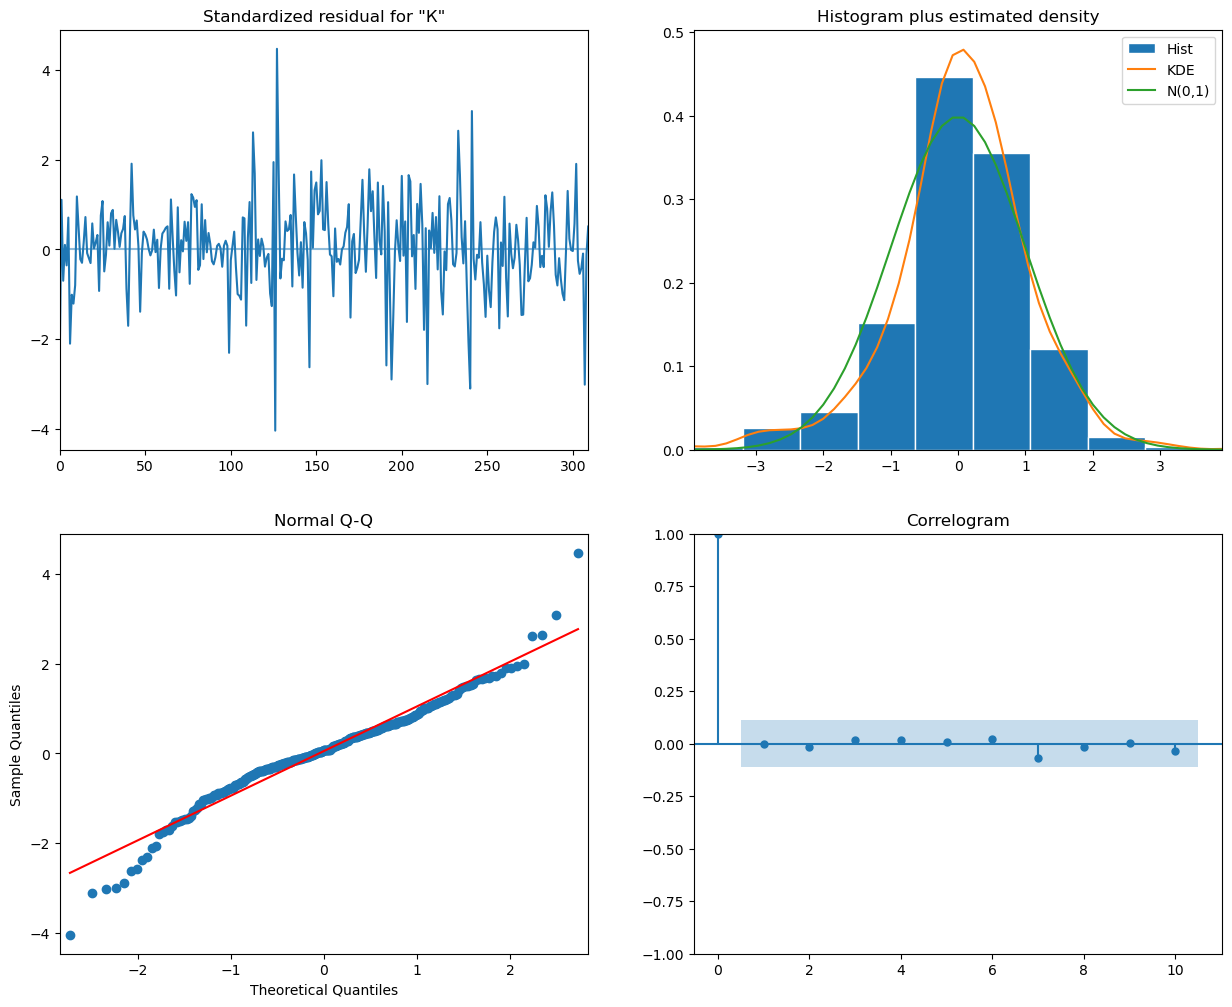

In [35]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
train, test = ydata[0:300], ydata[300:len(ydata)]

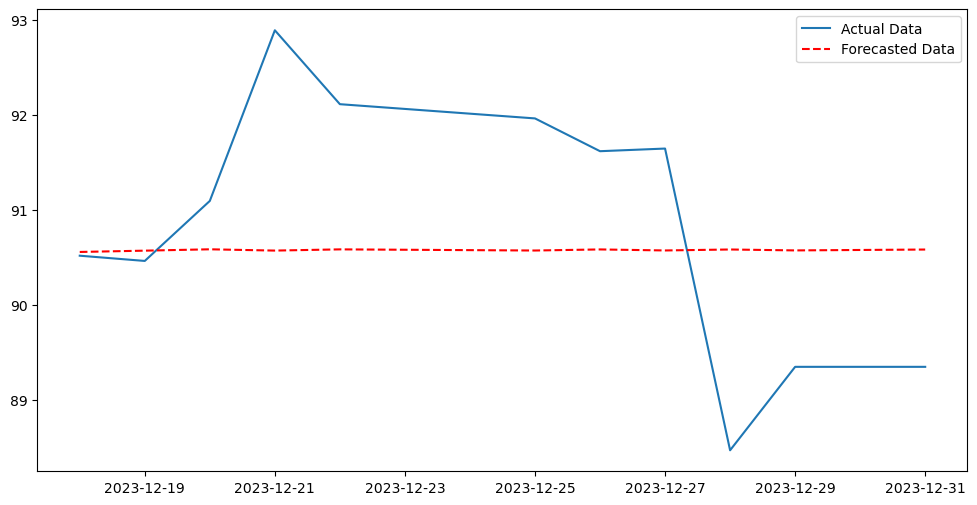

300    90.559792
301    90.573480
302    90.587773
303    90.574252
304    90.587042
305    90.574943
306    90.586389
307    90.575561
308    90.585804
309    90.576114
310    90.585280
Name: predicted_mean, dtype: float64
Test RMSE:  1.3354779181296812
MAPE:  0.012569113731365726


In [37]:
model = ARIMA(train, order=(1,1,3))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

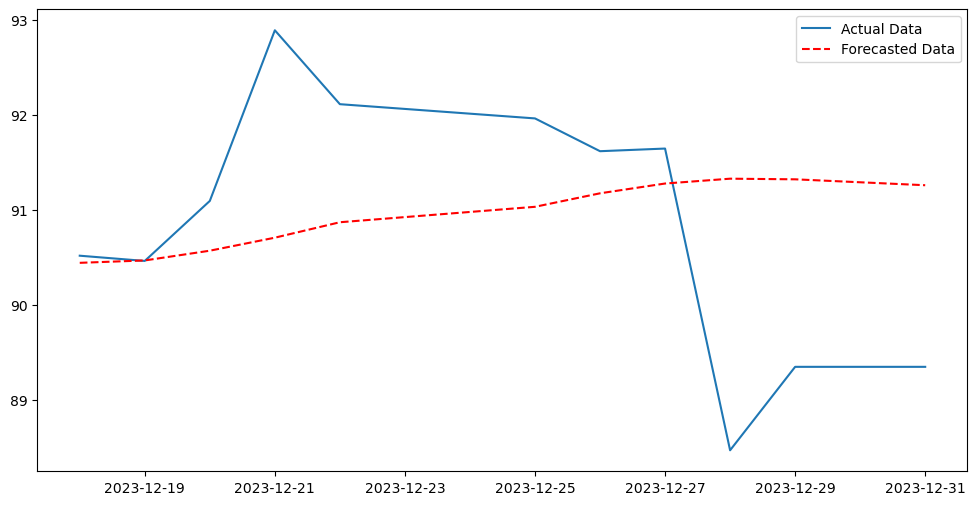

300    90.445396
301    90.470592
302    90.573072
303    90.709970
304    90.872502
305    91.034905
306    91.176985
307    91.279832
308    91.330799
309    91.324138
310    91.261954
Name: predicted_mean, dtype: float64
Test RMSE:  1.4614678337856015
MAPE:  0.012577370765049311


In [38]:
model = ARIMA(train, order=(3,1,2))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

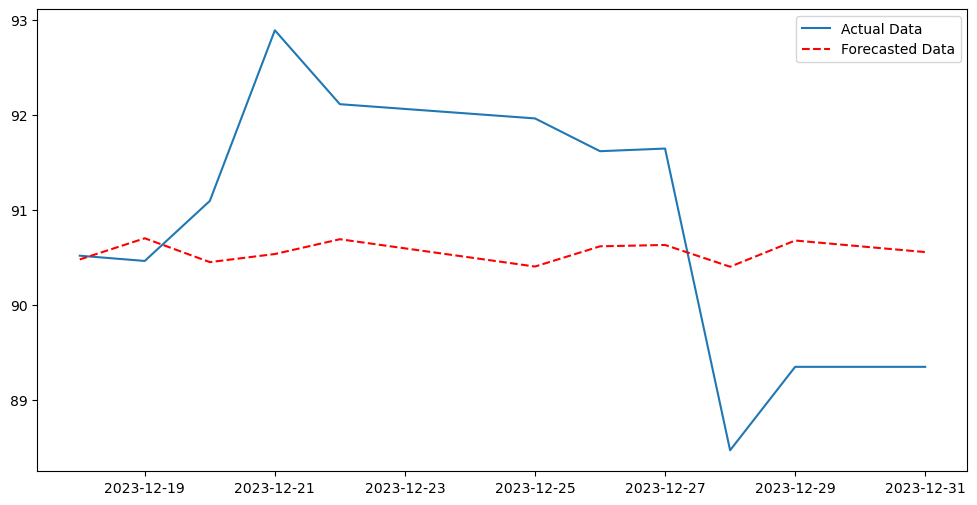

300    90.480988
301    90.703720
302    90.452843
303    90.538006
304    90.693618
305    90.406321
306    90.619137
307    90.633400
308    90.404510
309    90.680185
310    90.558400
Name: predicted_mean, dtype: float64
Test RMSE:  1.329771608027239
MAPE:  0.012734025525251123


In [39]:
model = ARIMA(train, order=(4,1,3))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

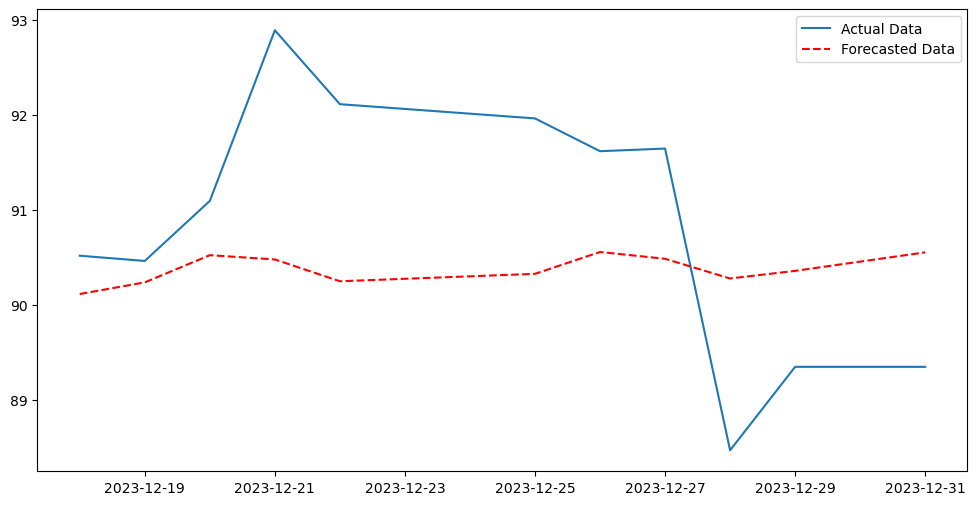

300    90.117325
301    90.239726
302    90.526010
303    90.480858
304    90.251377
305    90.329591
306    90.559586
307    90.487845
308    90.280796
309    90.360760
310    90.555579
Name: predicted_mean, dtype: float64
Test RMSE:  1.3721234842457473
MAPE:  0.013330038526730304


In [40]:
model = ARIMA(train, order=(4,1,4))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

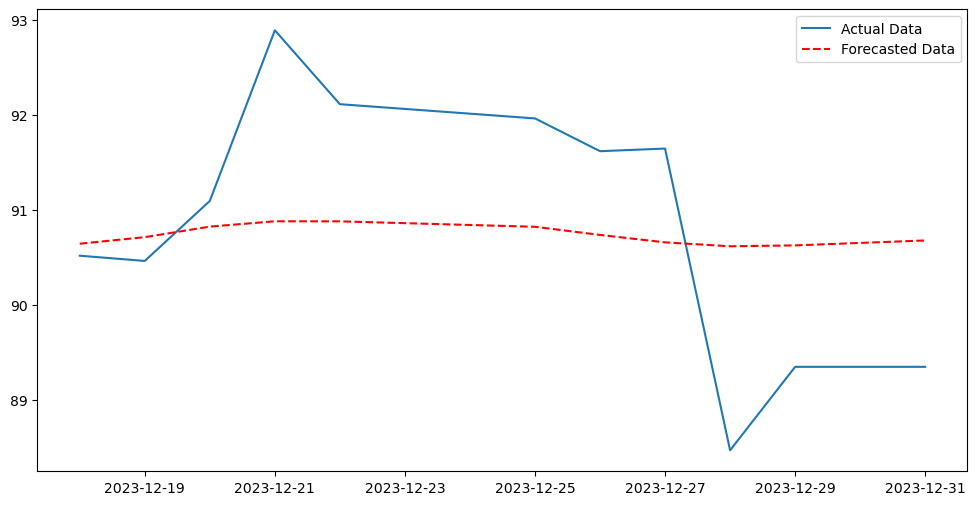

300    90.646625
301    90.715512
302    90.826434
303    90.882606
304    90.881939
305    90.824607
306    90.739123
307    90.660761
308    90.619713
309    90.628929
310    90.680705
Name: predicted_mean, dtype: float64
Test RMSE:  1.2347574829637484
MAPE:  0.011670877047866053


In [41]:
model = ARIMA(train, order=(3,1,4))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

### ARIMA 2016-2021

In [42]:
p = range(2, 10)
d = range(1, 2)
q = range(2, 10)

min_aic = np.inf
for i in p:
    for j in d:
        for k in q:
                model = ARIMA(data_new['Курс'], order=(i, j, k)).fit()
                aic = model.aic
                if aic < min_aic:
                    min_aic = aic
                    best_arima = (i, j, k)

print('Оптимальные параметры модели ARIMA:')
print('p:', best_arima[0])
print('d:', best_arima[1])
print('q:', best_arima[2])

Оптимальные параметры модели ARIMA:
p: 4
d: 1
q: 2


In [43]:
results_dict = {}

p_range = range(0, 10)
d_range = range(1, 2)
q_range = range(0, 10)

for p in p_range:
    for d in d_range:
        for q in q_range:

            model = ARIMA(data_new['Курс'], order=(p, d, q))

            res = model.fit()
            
            predictions = res.forecast()

            aic = res.aic
            bic = res.bic

            results_dict[(p, d, q)] = {'aic': aic, 'bic': bic}

sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1]['aic']))

for (p, d, q), result in sorted_results.items():
    print(f'p={p}, d={d}, q={q}: {result}')

p=2, d=1, q=0: {'aic': 299.0011534453286, 'bic': 305.78919307645253}
p=0, d=1, q=1: {'aic': 299.8210519511927, 'bic': 304.34641170527533}
p=4, d=1, q=2: {'aic': 300.9531454058566, 'bic': 316.7919045451458}
p=2, d=1, q=4: {'aic': 300.95948155304865, 'bic': 316.79824069233786}
p=0, d=1, q=3: {'aic': 300.96770508963294, 'bic': 310.01842459779823}
p=3, d=1, q=0: {'aic': 300.98829503837743, 'bic': 310.0390145465427}
p=2, d=1, q=1: {'aic': 300.99136812173435, 'bic': 310.04208762989964}
p=0, d=1, q=2: {'aic': 301.25749304976387, 'bic': 308.0455326808878}
p=3, d=1, q=3: {'aic': 301.3182958019014, 'bic': 317.1570549411906}
p=1, d=1, q=1: {'aic': 301.56787178988225, 'bic': 308.35591142100617}
p=1, d=1, q=2: {'aic': 302.5616170178428, 'bic': 311.6123365260081}
p=3, d=1, q=4: {'aic': 302.6265420358123, 'bic': 320.7279810521428}
p=0, d=1, q=4: {'aic': 302.7125038191228, 'bic': 314.0259032043294}
p=1, d=1, q=3: {'aic': 302.83474005328526, 'bic': 314.14813943849185}
p=4, d=1, q=0: {'aic': 302.8519008

In [44]:
model = ARIMA(data_new['Курс'], order=(1,1,2))
model_fit = model.fit()

print(model_fit.summary(alpha=0.05))

                               SARIMAX Results                                
Dep. Variable:                   Курс   No. Observations:                   72
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -147.281
Date:                Wed, 15 May 2024   AIC                            302.562
Time:                        17:10:25   BIC                            311.612
Sample:                    01-01-2016   HQIC                           306.161
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4086      0.765      0.534      0.593      -1.091       1.909
ma.L1         -0.0724      0.768     -0.094      0.925      -1.577       1.432
ma.L2         -0.2765      0.280     -0.989      0.3

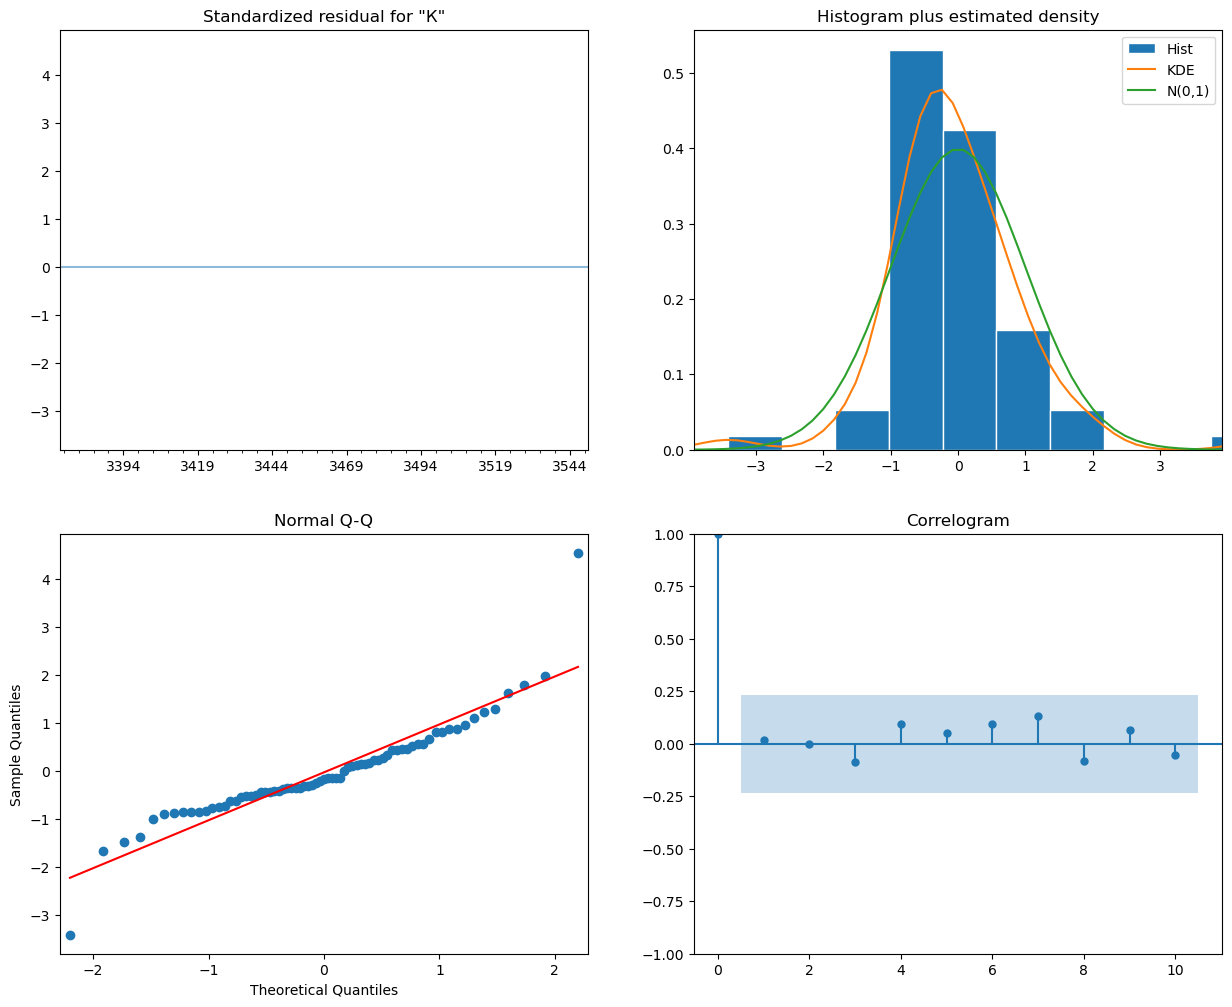

In [45]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [46]:
train_size = int(len(data_new) * 0.8)
train, test = data_new[0:train_size], data_new[train_size:len(data_new)]

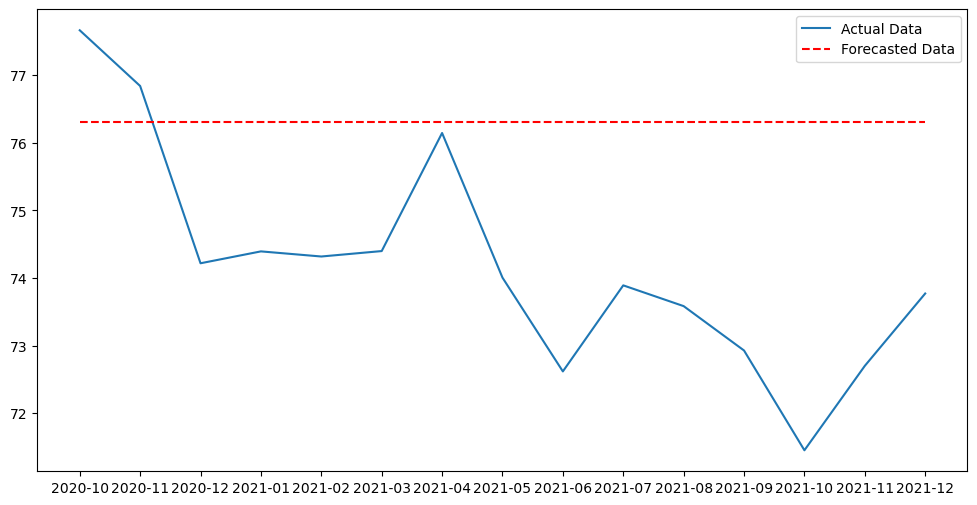

2020-10-01    76.304629
2020-11-01    76.304629
2020-12-01    76.304629
2021-01-01    76.304629
2021-02-01    76.304629
2021-03-01    76.304629
2021-04-01    76.304629
2021-05-01    76.304629
2021-06-01    76.304629
2021-07-01    76.304629
2021-08-01    76.304629
2021-09-01    76.304629
2021-10-01    76.304629
2021-11-01    76.304629
2021-12-01    76.304629
Freq: MS, Name: predicted_mean, dtype: float64
Test RMSE:  2.636973662278929
MAPE:  0.0321711267087826


In [47]:
model = ARIMA(train, order=(0,1,1))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

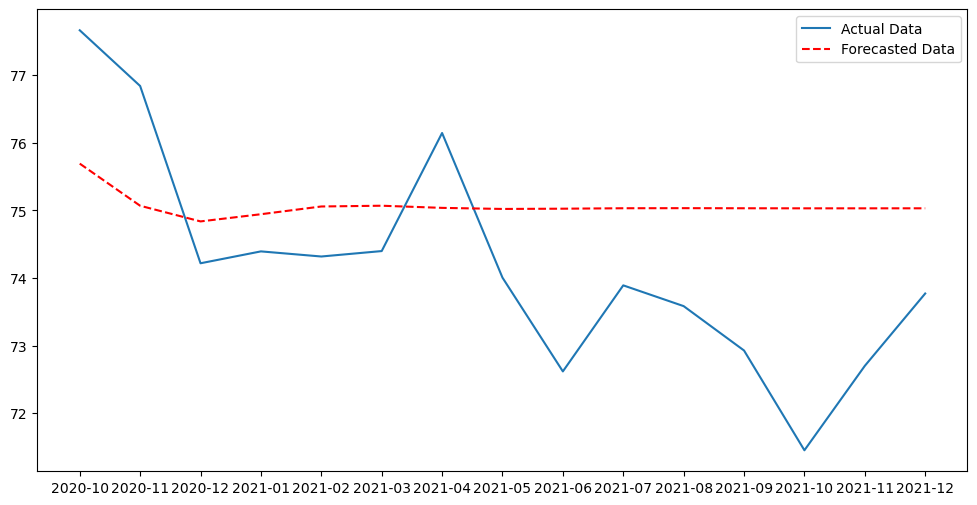

2020-10-01    75.690969
2020-11-01    75.067558
2020-12-01    74.835956
2021-01-01    74.942290
2021-02-01    75.056868
2021-03-01    75.068027
2021-04-01    75.036228
2021-05-01    75.020297
2021-06-01    75.024114
2021-07-01    75.030631
2021-08-01    75.031969
2021-09-01    75.030436
2021-10-01    75.029415
2021-11-01    75.029500
2021-12-01    75.029856
Freq: MS, Name: predicted_mean, dtype: float64
Test RMSE:  1.7210452702464096
MAPE:  0.020521674137951907


In [48]:
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

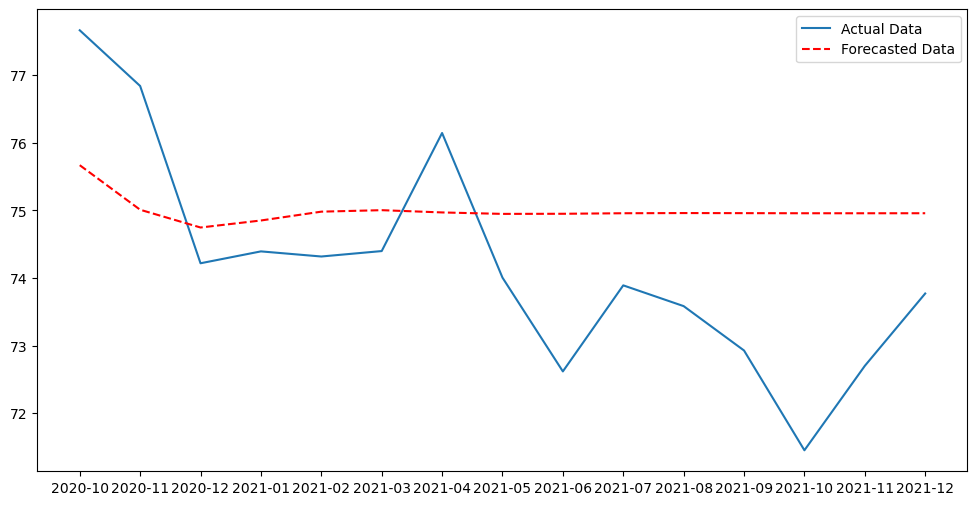

2020-10-01    75.667659
2020-11-01    75.008513
2020-12-01    74.745837
2021-01-01    74.849571
2021-02-01    74.980222
2021-03-01    75.002172
2021-04-01    74.968704
2021-05-01    74.947159
2021-06-01    74.948909
2021-07-01    74.956729
2021-08-01    74.959506
2021-09-01    74.958130
2021-10-01    74.956629
2021-11-01    74.956437
2021-12-01    74.956847
Freq: MS, Name: predicted_mean, dtype: float64
Test RMSE:  1.6793749756533547
MAPE:  0.01982596919669849


In [49]:
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

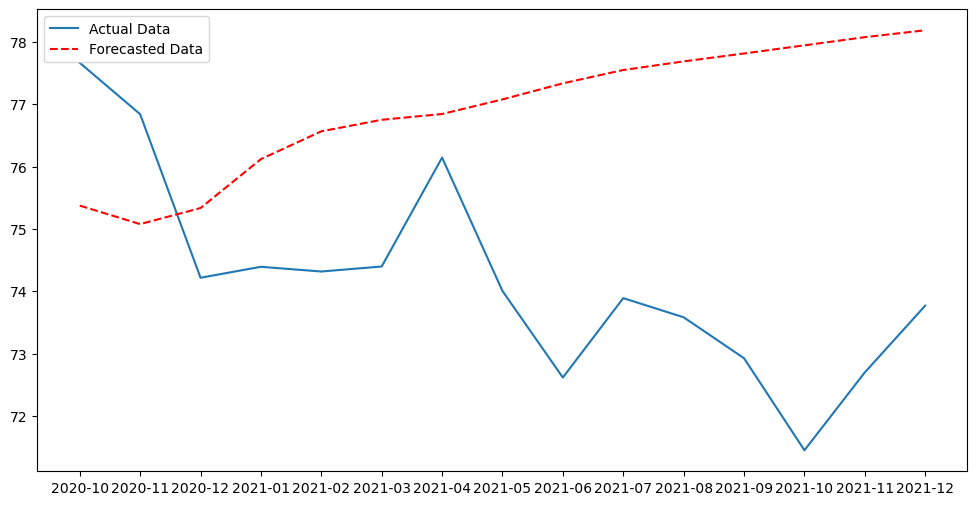

2020-10-01    75.373804
2020-11-01    75.076750
2020-12-01    75.334779
2021-01-01    76.119130
2021-02-01    76.564981
2021-03-01    76.749557
2021-04-01    76.842679
2021-05-01    77.076696
2021-06-01    77.334503
2021-07-01    77.548194
2021-08-01    77.686153
2021-09-01    77.813061
2021-10-01    77.943870
2021-11-01    78.074922
2021-12-01    78.185236
Freq: MS, Name: predicted_mean, dtype: float64
Test RMSE:  3.651733801712228
MAPE:  0.044347446777627364


In [50]:
model = ARIMA(train, order=(4,1,2))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

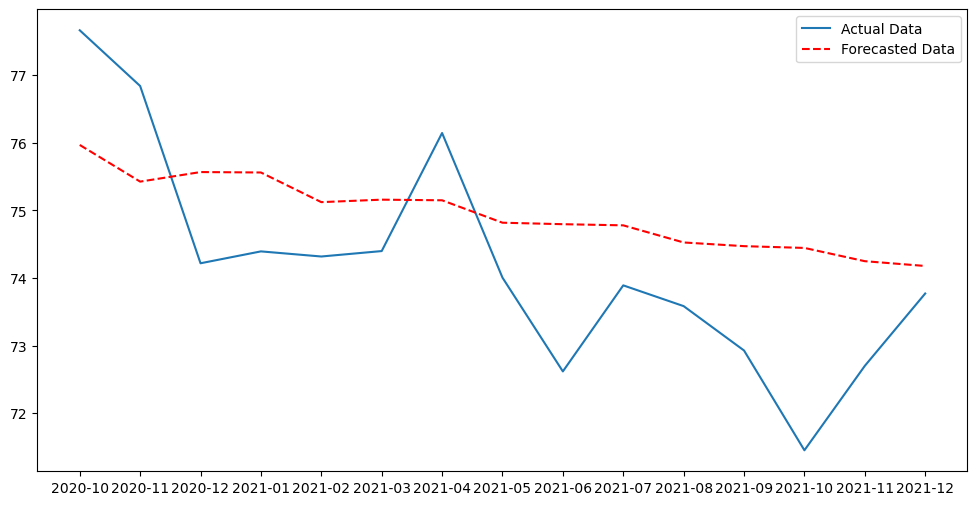

2020-10-01    75.967008
2020-11-01    75.424671
2020-12-01    75.566095
2021-01-01    75.559678
2021-02-01    75.121175
2021-03-01    75.157669
2021-04-01    75.148413
2021-05-01    74.816747
2021-06-01    74.794799
2021-07-01    74.777705
2021-08-01    74.524418
2021-09-01    74.469870
2021-10-01    74.443637
2021-11-01    74.247470
2021-12-01    74.176617
Freq: MS, Name: predicted_mean, dtype: float64
Test RMSE:  1.4437503741752717
MAPE:  0.017594634617557177


In [51]:
model = ARIMA(train, order=(4,1,3))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
 
print(predictions)
    
print('Test RMSE: ', sqrt(mean_squared_error(test, predictions)))
print('MAPE: ', mape(test, predictions))

### ARCH 2023

In [52]:
from statsmodels.stats.diagnostic import het_arch
arch_result = het_arch(ydata['Курс'])
if arch_result[3] < 0.05:
    print("arch effect.")
else:
    print("no arch effect.")

arch effect.


In [53]:
p = range(1, 15)

min_aic = np.inf
for i in p:
    model = arch_model(ydata['Курс'], vol='ARCH', p=i).fit()
    aic = model.aic
    if aic < min_aic:
        min_aic = aic
        best_arch = (i)

print('Оптимальные параметры модели ARCH:')
print('p:', best_arch)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2336.3557680405315
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1057.5647207800455
Iteration:      3,   Func. Count:     14,   Neg. LLF: 1260.733306671153
Iteration:      4,   Func. Count:     19,   Neg. LLF: 1365.699529987614
Iteration:      5,   Func. Count:     25,   Neg. LLF: 1148.4549161751356
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1509.1401963111568
Iteration:      7,   Func. Count:     35,   Neg. LLF: 2238.014156726319
Iteration:      8,   Func. Count:     40,   Neg. LLF: 2527.058071574147
Iteration:      9,   Func. Count:     45,   Neg. LLF: 1060.108536657162
Iteration:     10,   Func. Count:     50,   Neg. LLF: 1744.092480343132
Iteration:     11,   Func. Count:     55,   Neg. LLF: 1711.0692758139267
Iteration:     12,   Func. Count:     60,   Neg. LLF: 1135.539414241081
Iteration:     13,   Func. Count:     65,   Neg. LLF: 1550.315358888839
Iteration:     14,   Func. Count:     70,   Neg. LLF: 1451.

Iteration:      8,   Func. Count:     71,   Neg. LLF: 1023.4059105387987
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1022.8477533203522
Iteration:     10,   Func. Count:     89,   Neg. LLF: 1020.8631500971824
Iteration:     11,   Func. Count:     98,   Neg. LLF: 1019.4497595094393
Iteration:     12,   Func. Count:    107,   Neg. LLF: 1023.5480259492977
Iteration:     13,   Func. Count:    116,   Neg. LLF: 1263.3849885012637
Iteration:     14,   Func. Count:    125,   Neg. LLF: 1053.7919419849122
Iteration:     15,   Func. Count:    134,   Neg. LLF: 2993.1023097828956
Iteration:     16,   Func. Count:    143,   Neg. LLF: 1111.0834029805956
Iteration:     17,   Func. Count:    152,   Neg. LLF: 981.5627899371142
Iteration:     18,   Func. Count:    160,   Neg. LLF: 981.3719603185181
Iteration:     19,   Func. Count:    168,   Neg. LLF: 1612.1393857022344
Iteration:     20,   Func. Count:    178,   Neg. LLF: 981.206944734654
Iteration:     21,   Func. Count:    186,   Neg. LLF: 9

Iteration:     12,   Func. Count:    155,   Neg. LLF: 1058.9195839543854
Iteration:     13,   Func. Count:    168,   Neg. LLF: 1040.4188522982226
Iteration:     14,   Func. Count:    181,   Neg. LLF: 1076.2115087018415
Iteration:     15,   Func. Count:    194,   Neg. LLF: 1051.8418549322178
Iteration:     16,   Func. Count:    207,   Neg. LLF: 1060.0565042710161
Iteration:     17,   Func. Count:    220,   Neg. LLF: 1057.4108896098062
Iteration:     18,   Func. Count:    233,   Neg. LLF: 1057.9685404608647
Iteration:     19,   Func. Count:    246,   Neg. LLF: 1055.0299034724003
Iteration:     20,   Func. Count:    259,   Neg. LLF: 987.9058505683369
Iteration:     21,   Func. Count:    272,   Neg. LLF: 983.1283846249511
Iteration:     22,   Func. Count:    285,   Neg. LLF: 982.6896838127499
Iteration:     23,   Func. Count:    297,   Neg. LLF: 982.278135965269
Iteration:     24,   Func. Count:    309,   Neg. LLF: 981.5763732361129
Iteration:     25,   Func. Count:    321,   Neg. LLF: 981

Iteration:      1,   Func. Count:     18,   Neg. LLF: 1059.8731923471314
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1037.7475468938972
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1338.0779819589316
Iteration:      4,   Func. Count:     70,   Neg. LLF: 198164590.117071
Iteration:      5,   Func. Count:     88,   Neg. LLF: 1916.046916688636
Iteration:      6,   Func. Count:    106,   Neg. LLF: 1076.9533288326952
Iteration:      7,   Func. Count:    124,   Neg. LLF: 7092.571338649341
Iteration:      8,   Func. Count:    142,   Neg. LLF: 1017.756374969573
Iteration:      9,   Func. Count:    160,   Neg. LLF: 3690.6352977185174
Iteration:     10,   Func. Count:    178,   Neg. LLF: 1026.3714282592828
Iteration:     11,   Func. Count:    196,   Neg. LLF: 1262.6088375370111
Iteration:     12,   Func. Count:    214,   Neg. LLF: 990.435910371943
Iteration:     13,   Func. Count:    232,   Neg. LLF: 1035.9691503739382
Iteration:     14,   Func. Count:    250,   Neg. LLF: 1066

In [54]:
am = arch_model(ydata['Курс'], mean='ARX', vol='ARCH', p=1)

split_date = dt.datetime(2023,12,1)

res = am.fit(last_obs=split_date)

print(res.summary())

forecast = res.forecast(horizon=1, start=split_date)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2653.1943246549063
Iteration:      2,   Func. Count:     10,   Neg. LLF: 6530.373368491217
Iteration:      3,   Func. Count:     15,   Neg. LLF: 130344.68225515117
Iteration:      4,   Func. Count:     20,   Neg. LLF: 963.9448216404222
Iteration:      5,   Func. Count:     24,   Neg. LLF: 953.9708436114148
Iteration:      6,   Func. Count:     28,   Neg. LLF: 101047.30537645519
Iteration:      7,   Func. Count:     33,   Neg. LLF: 1821.2112194331926
Iteration:      8,   Func. Count:     38,   Neg. LLF: 1106.7177479592635
Iteration:      9,   Func. Count:     43,   Neg. LLF: 1043.0071823163546
Iteration:     10,   Func. Count:     48,   Neg. LLF: 1867.3028725795964
Iteration:     11,   Func. Count:     53,   Neg. LLF: 1728.9607980897786
Iteration:     12,   Func. Count:     58,   Neg. LLF: 9384.027931981584
Iteration:     13,   Func. Count:     63,   Neg. LLF: 2894.9054641250946
Iteration:     14,   Func. Count:     68,   Neg. LLF: 4

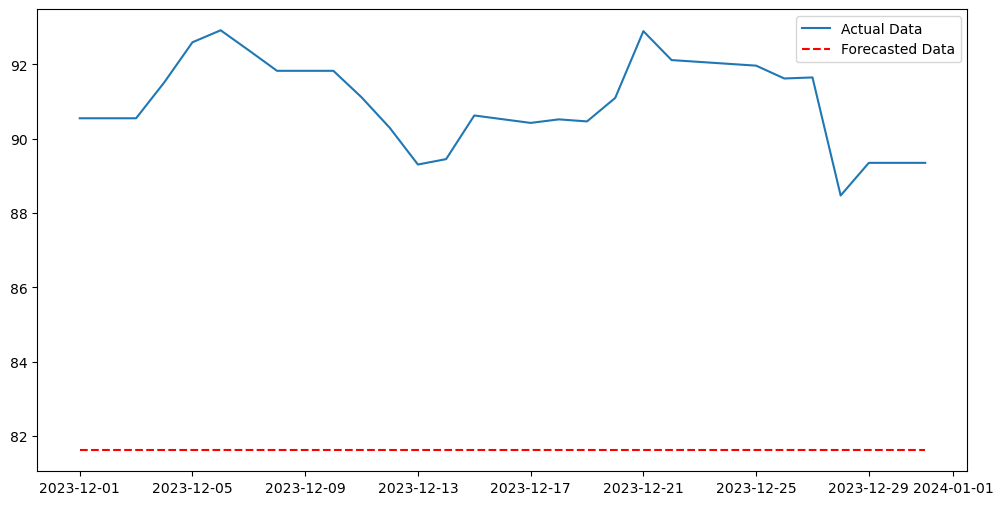

Test RMSE:  9.448134587008177
MAPE:  0.10285376143960727


In [55]:
plt.figure(figsize=(12,6))
plt.plot(ydata['Курс']['2023-12-1':], label='Actual Data')
plt.plot(forecast.mean[split_date:], label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
print('Test RMSE: ', sqrt(mean_squared_error(ydata['Курс']['2023-12-1':], forecast.mean[split_date:])))
print('MAPE: ', mape(ydata['Курс']['2023-12-1':], forecast.mean[split_date:]))

<Axes: xlabel='Дата'>

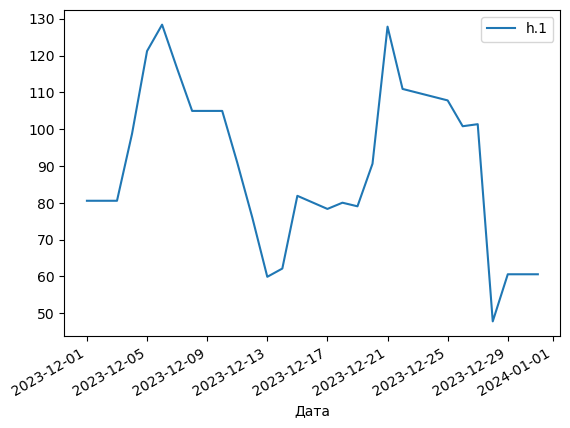

In [56]:
forecast.variance[split_date:].plot()

In [57]:
print('Test RMSE: ', sqrt(mean_squared_error(ydata['Курс']['2023-12-1':], forecast.mean[split_date:])))
print('MAPE: ', mape(ydata['Курс']['2023-12-1':], forecast.mean[split_date:]))

Test RMSE:  9.448134587008177
MAPE:  0.10285376143960727


### ARCH 2016-2021

In [58]:
arch_result = het_arch(data_new['Курс'])
if arch_result[3] < 0.05:
    print("arch effect.")
else:
    print("no arch effect.")

arch effect.


In [59]:
p = range(1, 15)

min_aic = np.inf
for i in p:
    model = arch_model(data_new['Курс'], vol='ARCH', p=i).fit()
    aic = model.aic
    if aic < min_aic:
        min_aic = aic
        best_arch = i

print('Оптимальные параметры модели ARCH:')
print('p:', best_arch)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 226.16515056421179
Iteration:      2,   Func. Count:     10,   Neg. LLF: 213.16879149040784
Iteration:      3,   Func. Count:     14,   Neg. LLF: 259.48637776554324
Iteration:      4,   Func. Count:     19,   Neg. LLF: 212.83503527322546
Iteration:      5,   Func. Count:     23,   Neg. LLF: 212.7137282747361
Iteration:      6,   Func. Count:     27,   Neg. LLF: 212.63713289440966
Iteration:      7,   Func. Count:     31,   Neg. LLF: 212.6197263552395
Iteration:      8,   Func. Count:     35,   Neg. LLF: 212.61341460707132
Iteration:      9,   Func. Count:     39,   Neg. LLF: 212.61315018768906
Iteration:     10,   Func. Count:     43,   Neg. LLF: 212.61314755444909
Iteration:     11,   Func. Count:     46,   Neg. LLF: 212.6131476095003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 212.61314755444909
            Iterations: 11
            Function evaluations: 46
            Gradient evalua

Iteration:      4,   Func. Count:     46,   Neg. LLF: 225.64720926907904
Iteration:      5,   Func. Count:     58,   Neg. LLF: 251.274527963318
Iteration:      6,   Func. Count:     70,   Neg. LLF: 243.7579982573221
Iteration:      7,   Func. Count:     82,   Neg. LLF: 252.94445843882312
Iteration:      8,   Func. Count:     94,   Neg. LLF: 271.3823710577103
Iteration:      9,   Func. Count:    106,   Neg. LLF: 238.136668568787
Iteration:     10,   Func. Count:    118,   Neg. LLF: 285.3620565734682
Iteration:     11,   Func. Count:    130,   Neg. LLF: 233.88546851906787
Iteration:     12,   Func. Count:    142,   Neg. LLF: 250.05392482959624
Iteration:     13,   Func. Count:    154,   Neg. LLF: 220.01061962551876
Iteration:     14,   Func. Count:    166,   Neg. LLF: 218.57846174700177
Iteration:     15,   Func. Count:    178,   Neg. LLF: 218.58427731622902
Iteration:     16,   Func. Count:    190,   Neg. LLF: 236.01574107607883
Iteration:     17,   Func. Count:    202,   Neg. LLF: 217.

Iteration:      6,   Func. Count:     92,   Neg. LLF: 213.80246734324004
Iteration:      7,   Func. Count:    107,   Neg. LLF: 219.94649368361596
Iteration:      8,   Func. Count:    123,   Neg. LLF: 224.5568687792289
Iteration:      9,   Func. Count:    140,   Neg. LLF: 216.6777143377232
Iteration:     10,   Func. Count:    156,   Neg. LLF: 223.3089218795721
Iteration:     11,   Func. Count:    172,   Neg. LLF: 211.706558877012
Iteration:     12,   Func. Count:    188,   Neg. LLF: 212.0985820229861
Iteration:     13,   Func. Count:    204,   Neg. LLF: 210.973359260581
Iteration:     14,   Func. Count:    219,   Neg. LLF: 211.0069270393197
Iteration:     15,   Func. Count:    235,   Neg. LLF: 211.4256440457661
Iteration:     16,   Func. Count:    251,   Neg. LLF: 210.92303409502222
Iteration:     17,   Func. Count:    266,   Neg. LLF: 210.9213552558772
Iteration:     18,   Func. Count:    281,   Neg. LLF: 210.92062790547072
Iteration:     19,   Func. Count:    296,   Neg. LLF: 210.9206

In [60]:
train_size = int(len(data_new) * 0.7)
train, test = data_new['Курс'][0:train_size], data_new['Курс'][train_size:len(data_new)]

In [61]:
am = arch_model(data_new['Курс'], mean='ARX', vol='ARCH', p=2)

res = am.fit(last_obs=len(train))

print(res.summary())

forecast = res.forecast(horizon=1, start=(len(data_new) - len(test)))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 158.7126705980963
Iteration:      2,   Func. Count:     12,   Neg. LLF: 123.26745163014581
Iteration:      3,   Func. Count:     17,   Neg. LLF: 123.74437036981355
Iteration:      4,   Func. Count:     23,   Neg. LLF: 123.17130414070138
Iteration:      5,   Func. Count:     29,   Neg. LLF: 123.1684663410457
Iteration:      6,   Func. Count:     35,   Neg. LLF: 123.16327691698851
Iteration:      7,   Func. Count:     40,   Neg. LLF: 123.1632039103548
Iteration:      8,   Func. Count:     44,   Neg. LLF: 123.16320396672138
Optimization terminated successfully    (Exit mode 0)
            Current function value: 123.1632039103548
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
                           AR - ARCH Model Results                            
Dep. Variable:                   Курс   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared

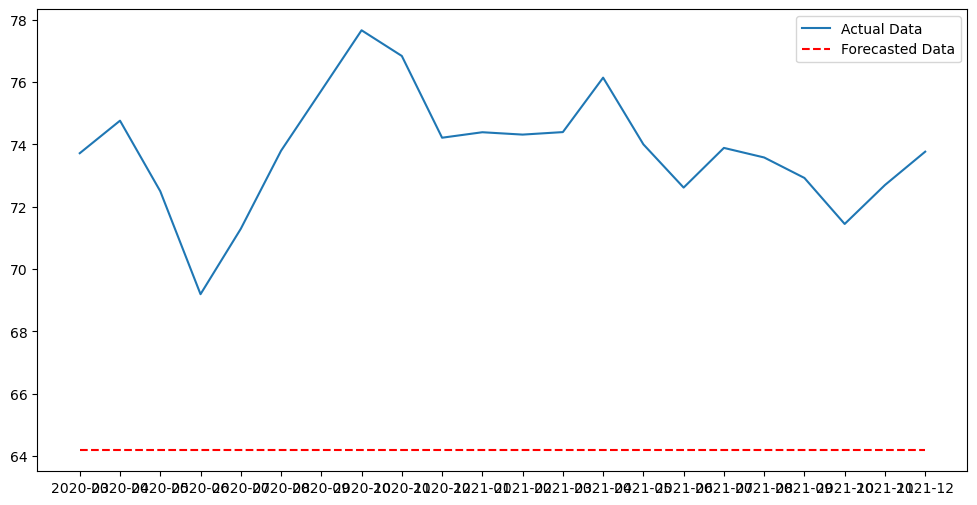

Test RMSE:  9.796881208966635
MAPE:  0.12985191762011664


In [62]:
plt.figure(figsize=(12,6))
plt.plot(data_new['Курс'][50:], label='Actual Data')
plt.plot(forecast.mean, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
print('Test RMSE: ', sqrt(mean_squared_error(data_new['Курс'][50:], forecast.mean)))
print('MAPE: ', mape(data_new['Курс'][50:], forecast.mean))

<Axes: xlabel='Дата'>

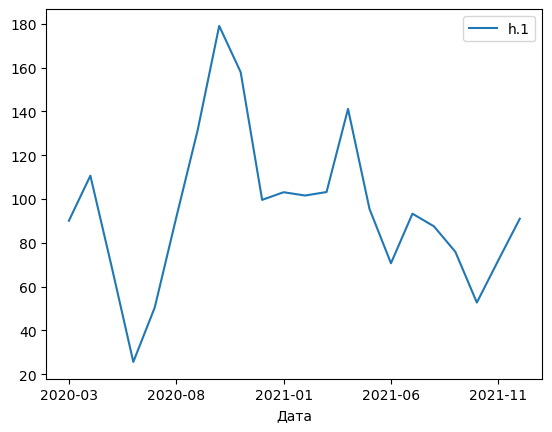

In [63]:
forecast.variance.plot()

### GARCH 2023

In [64]:
p = range(1, 15)
q = range(1, 15)

min_aic = np.inf
for i in p:
    for j in q:
        model = arch_model(ydata['Курс'], vol='GARCH', p=i, q=j).fit()
        aic = model.aic
        if aic < min_aic:
            min_aic = aic
            best_arch = (i, j)

print('Оптимальные параметры модели GARCH:')
print('p:', best_arch[0])
print('q:', best_arch[1])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 137237397.9483779
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1058.5419523923774
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3843.6808272250546
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1426.55380054617
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1128.1013782577277
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1048.222096989914
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1021.0365155887537
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1150.1661388868915
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1031.840330690481
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1070.5146941061407
Iteration:     11,   Func. Count:     68,   Neg. LLF: 984.3108425924919
Iteration:     12,   Func. Count:     74,   Neg. LLF: 981.3964811171044
Iteration:     13,   Func. Count:     80,   Neg. LLF: 981.2466452871661
Iteration:     14,   Func. Count:     85,   Neg. LLF: 981.2

Iteration:      4,   Func. Count:     44,   Neg. LLF: 1621.8118523861608
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1021.3320376013219
Iteration:      6,   Func. Count:     67,   Neg. LLF: 1059.1548958033454
Iteration:      7,   Func. Count:     79,   Neg. LLF: 1031.2214962738808
Iteration:      8,   Func. Count:     90,   Neg. LLF: 1015.5658197732056
Iteration:      9,   Func. Count:    101,   Neg. LLF: 1017.4162267578375
Iteration:     10,   Func. Count:    112,   Neg. LLF: 981.9187314547083
Iteration:     11,   Func. Count:    122,   Neg. LLF: 1075.6039911497617
Iteration:     12,   Func. Count:    133,   Neg. LLF: 982.5772349712407
Iteration:     13,   Func. Count:    144,   Neg. LLF: 981.2517088762673
Iteration:     14,   Func. Count:    154,   Neg. LLF: 981.244184542034
Iteration:     15,   Func. Count:    164,   Neg. LLF: 981.2433032078993
Iteration:     16,   Func. Count:    174,   Neg. LLF: 981.2432931064297
Iteration:     17,   Func. Count:    183,   Neg. LLF: 981.

Iteration:     11,   Func. Count:    177,   Neg. LLF: 1131.1866122081215
Iteration:     12,   Func. Count:    193,   Neg. LLF: 1159.9066872211465
Iteration:     13,   Func. Count:    209,   Neg. LLF: 22557.251771692376
Iteration:     14,   Func. Count:    225,   Neg. LLF: 1204.7231866646941
Iteration:     15,   Func. Count:    241,   Neg. LLF: 3176.3456840969498
Iteration:     16,   Func. Count:    257,   Neg. LLF: 1312.466814237824
Iteration:     17,   Func. Count:    273,   Neg. LLF: 1738.4480887156803
Iteration:     18,   Func. Count:    289,   Neg. LLF: 1346.611749778151
Iteration:     19,   Func. Count:    305,   Neg. LLF: 2319.499253633422
Iteration:     20,   Func. Count:    321,   Neg. LLF: 1494.1618748868411
Iteration:     21,   Func. Count:    337,   Neg. LLF: 1983.2056089763005
Iteration:     22,   Func. Count:    353,   Neg. LLF: 1341.441909402911
Iteration:     23,   Func. Count:    369,   Neg. LLF: 1078.5641449943241
Iteration:     24,   Func. Count:    385,   Neg. LLF: 1

Iteration:     19,   Func. Count:    363,   Neg. LLF: 991.338710460918
Iteration:     20,   Func. Count:    382,   Neg. LLF: 1023.1652860343515
Iteration:     21,   Func. Count:    401,   Neg. LLF: 1034.3058191439468
Iteration:     22,   Func. Count:    420,   Neg. LLF: 982.7826925143033
Iteration:     23,   Func. Count:    439,   Neg. LLF: 981.2838443901448
Iteration:     24,   Func. Count:    457,   Neg. LLF: 981.2563418719936
Iteration:     25,   Func. Count:    475,   Neg. LLF: 981.2460172678086
Iteration:     26,   Func. Count:    493,   Neg. LLF: 981.2433574294953
Iteration:     27,   Func. Count:    511,   Neg. LLF: 981.243332953672
Iteration:     28,   Func. Count:    529,   Neg. LLF: 981.2433015295188
Iteration:     29,   Func. Count:    547,   Neg. LLF: 981.2432930273566
Iteration:     30,   Func. Count:    564,   Neg. LLF: 981.2432976161256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.2432930273566
            Iterations: 31
 

Iteration:     11,   Func. Count:    134,   Neg. LLF: 1024.0195690223586
Iteration:     12,   Func. Count:    146,   Neg. LLF: 1033.2497606901431
Iteration:     13,   Func. Count:    158,   Neg. LLF: 982.2096797722872
Iteration:     14,   Func. Count:    169,   Neg. LLF: 982.1710436919378
Iteration:     15,   Func. Count:    181,   Neg. LLF: 983.8343953130071
Iteration:     16,   Func. Count:    193,   Neg. LLF: 982.6451787334063
Iteration:     17,   Func. Count:    205,   Neg. LLF: 981.2145963948459
Iteration:     18,   Func. Count:    216,   Neg. LLF: 981.1856809654704
Iteration:     19,   Func. Count:    227,   Neg. LLF: 981.1792973295193
Iteration:     20,   Func. Count:    238,   Neg. LLF: 981.1761789010991
Iteration:     21,   Func. Count:    249,   Neg. LLF: 981.1757321468824
Iteration:     22,   Func. Count:    260,   Neg. LLF: 981.1756395700041
Iteration:     23,   Func. Count:    271,   Neg. LLF: 981.1756377931945
Iteration:     24,   Func. Count:    281,   Neg. LLF: 981.1756

Iteration:     18,   Func. Count:    282,   Neg. LLF: 981.2342536525179
Iteration:     19,   Func. Count:    297,   Neg. LLF: 981.1983015267219
Iteration:     20,   Func. Count:    312,   Neg. LLF: 981.1786374319447
Iteration:     21,   Func. Count:    327,   Neg. LLF: 981.1761513293739
Iteration:     22,   Func. Count:    342,   Neg. LLF: 981.1757463012761
Iteration:     23,   Func. Count:    357,   Neg. LLF: 981.1756426098711
Iteration:     24,   Func. Count:    372,   Neg. LLF: 981.1756379136898
Iteration:     25,   Func. Count:    386,   Neg. LLF: 981.1756398057385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756379136898
            Iterations: 25
            Function evaluations: 386
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2788.534529536994
Iteration:      2,   Func. Count:     34,   Neg. LLF: 12656.049285741143
Iteration:      3,   Func. Count:     51,   Neg. LLF: 1707.1579518738

Iteration:     18,   Func. Count:    359,   Neg. LLF: 981.1756463668585
Iteration:     19,   Func. Count:    378,   Neg. LLF: 981.2331095043337
Iteration:     20,   Func. Count:    399,   Neg. LLF: 981.1847520542411
Iteration:     21,   Func. Count:    420,   Neg. LLF: 981.1763417381901
Iteration:     22,   Func. Count:    441,   Neg. LLF: 981.1825960994577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756382891988
            Iterations: 25
            Function evaluations: 443
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      8,   Neg. LLF: 136600624.2868851
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1053.7195119923822
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1214.492596444887
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3862.0349602415317
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1524.409168108676
Iteration:      6,   Func. Count:     49,   Neg. LLF: 32913.87431952

Iteration:     24,   Func. Count:    283,   Neg. LLF: 981.1756750060804
Iteration:     25,   Func. Count:    294,   Neg. LLF: 981.1756403558381
Iteration:     26,   Func. Count:    305,   Neg. LLF: 981.1756378138859
Iteration:     27,   Func. Count:    315,   Neg. LLF: 981.1756379922392
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756378138859
            Iterations: 27
            Function evaluations: 315
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     13,   Neg. LLF: 135566840.69053093
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2328.8240428746017
Iteration:      3,   Func. Count:     40,   Neg. LLF: 4810.8496066798725
Iteration:      4,   Func. Count:     53,   Neg. LLF: 1281.7286001262632
Iteration:      5,   Func. Count:     66,   Neg. LLF: 1174.990520001035
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1067.3099155070067
Iteration:      7,   Func. Count:     92,   Neg. LLF: 1022.871029

Iteration:     20,   Func. Count:    315,   Neg. LLF: 981.1776914520738
Iteration:     21,   Func. Count:    330,   Neg. LLF: 981.1763310900704
Iteration:     22,   Func. Count:    345,   Neg. LLF: 981.1757362024239
Iteration:     23,   Func. Count:    360,   Neg. LLF: 981.1756450441262
Iteration:     24,   Func. Count:    375,   Neg. LLF: 981.1756380466946
Iteration:     25,   Func. Count:    389,   Neg. LLF: 981.1756396930507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756380466946
            Iterations: 25
            Function evaluations: 389
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2777.102786850491
Iteration:      2,   Func. Count:     34,   Neg. LLF: 2964.823313252448
Iteration:      3,   Func. Count:     51,   Neg. LLF: 1628.4997497861352
Iteration:      4,   Func. Count:     68,   Neg. LLF: 1211.3656664348496
Iteration:      5,   Func. Count:     85,   Neg. LLF: 2672.915850001

Iteration:     22,   Func. Count:    417,   Neg. LLF: 981.2234605273401
Iteration:     23,   Func. Count:    435,   Neg. LLF: 981.1951987627359
Iteration:     24,   Func. Count:    453,   Neg. LLF: 981.1840575160866
Iteration:     25,   Func. Count:    471,   Neg. LLF: 981.1768614580985
Iteration:     26,   Func. Count:    489,   Neg. LLF: 981.1757984070862
Iteration:     27,   Func. Count:    507,   Neg. LLF: 981.175660191295
Iteration:     28,   Func. Count:    525,   Neg. LLF: 981.1756439472599
Iteration:     29,   Func. Count:    543,   Neg. LLF: 981.1756396724354
Iteration:     30,   Func. Count:    561,   Neg. LLF: 981.1756381426294
Iteration:     31,   Func. Count:    578,   Neg. LLF: 981.1756406109369
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756381426294
            Iterations: 31
            Function evaluations: 578
            Gradient evaluations: 31
Iteration:      1,   Func. Count:     20,   Neg. LLF: 2773.46582852181


Iteration:     15,   Func. Count:    167,   Neg. LLF: 981.5663970965226
Iteration:     16,   Func. Count:    178,   Neg. LLF: 981.5310660675202
Iteration:     17,   Func. Count:    189,   Neg. LLF: 981.3066714893678
Iteration:     18,   Func. Count:    199,   Neg. LLF: 981.2810559684553
Iteration:     19,   Func. Count:    209,   Neg. LLF: 981.267036808762
Iteration:     20,   Func. Count:    219,   Neg. LLF: 981.2154889349995
Iteration:     21,   Func. Count:    229,   Neg. LLF: 981.1866684725402
Iteration:     22,   Func. Count:    239,   Neg. LLF: 981.1764703208081
Iteration:     23,   Func. Count:    249,   Neg. LLF: 981.1756741943295
Iteration:     24,   Func. Count:    259,   Neg. LLF: 981.1756382730513
Iteration:     25,   Func. Count:    268,   Neg. LLF: 981.1756383580755
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756382730513
            Iterations: 25
            Function evaluations: 268
            Gradient evaluations: 25

Iteration:      3,   Func. Count:     48,   Neg. LLF: 1513.5961587161455
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1388.792381001287
Iteration:      5,   Func. Count:     81,   Neg. LLF: 38831.2597090695
Iteration:      6,   Func. Count:     97,   Neg. LLF: 1126.2406666307597
Iteration:      7,   Func. Count:    113,   Neg. LLF: 1172.110580103615
Iteration:      8,   Func. Count:    129,   Neg. LLF: 1035.359685760852
Iteration:      9,   Func. Count:    145,   Neg. LLF: 1052.8114026845274
Iteration:     10,   Func. Count:    161,   Neg. LLF: 1058.527476478953
Iteration:     11,   Func. Count:    177,   Neg. LLF: 2369.8121089308042
Iteration:     12,   Func. Count:    193,   Neg. LLF: 1049.1099234069952
Iteration:     13,   Func. Count:    209,   Neg. LLF: 1839.1435336236332
Iteration:     14,   Func. Count:    225,   Neg. LLF: 1058.313267096335
Iteration:     15,   Func. Count:    241,   Neg. LLF: 1092.3319433268775
Iteration:     16,   Func. Count:    257,   Neg. LLF: 1042

Iteration:     35,   Func. Count:    656,   Neg. LLF: 981.1766764699071
Iteration:     36,   Func. Count:    674,   Neg. LLF: 981.1759995641818
Iteration:     37,   Func. Count:    692,   Neg. LLF: 981.1756950638749
Iteration:     38,   Func. Count:    710,   Neg. LLF: 981.1756412679867
Iteration:     39,   Func. Count:    728,   Neg. LLF: 981.175637965722
Iteration:     40,   Func. Count:    745,   Neg. LLF: 981.1756400950387
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.175637965722
            Iterations: 40
            Function evaluations: 745
            Gradient evaluations: 40
Iteration:      1,   Func. Count:     20,   Neg. LLF: 2760.0294798196205
Iteration:      2,   Func. Count:     40,   Neg. LLF: 1955.2455628503214
Iteration:      3,   Func. Count:     60,   Neg. LLF: 1855.009197896312
Iteration:      4,   Func. Count:     81,   Neg. LLF: 1994.4772438271166
Iteration:      5,   Func. Count:    102,   Neg. LLF: 1023.3171489424

Iteration:     18,   Func. Count:    197,   Neg. LLF: 981.1781168396811
Iteration:     19,   Func. Count:    207,   Neg. LLF: 981.1776847044727
Iteration:     20,   Func. Count:    217,   Neg. LLF: 981.1765629627471
Iteration:     21,   Func. Count:    227,   Neg. LLF: 981.1758895862914
Iteration:     22,   Func. Count:    237,   Neg. LLF: 981.1756592492152
Iteration:     23,   Func. Count:    247,   Neg. LLF: 981.1756389032391
Iteration:     24,   Func. Count:    257,   Neg. LLF: 981.1756379445935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756379445935
            Iterations: 24
            Function evaluations: 257
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     12,   Neg. LLF: 495272.86596158776
Iteration:      2,   Func. Count:     25,   Neg. LLF: 1169.5379721994502
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1074.606821416154
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1085.500800267

Iteration:      8,   Func. Count:    133,   Neg. LLF: 1006.2228835166917
Iteration:      9,   Func. Count:    149,   Neg. LLF: 982.2770705421824
Iteration:     10,   Func. Count:    165,   Neg. LLF: 981.7129502906603
Iteration:     11,   Func. Count:    180,   Neg. LLF: 981.6262020084821
Iteration:     12,   Func. Count:    195,   Neg. LLF: 981.603351982546
Iteration:     13,   Func. Count:    210,   Neg. LLF: 981.5714410639973
Iteration:     14,   Func. Count:    225,   Neg. LLF: 981.4591915739254
Iteration:     15,   Func. Count:    240,   Neg. LLF: 981.3439163399248
Iteration:     16,   Func. Count:    255,   Neg. LLF: 981.2677970507464
Iteration:     17,   Func. Count:    270,   Neg. LLF: 981.2507283926966
Iteration:     18,   Func. Count:    285,   Neg. LLF: 981.2492086963041
Iteration:     19,   Func. Count:    300,   Neg. LLF: 981.248990037575
Iteration:     20,   Func. Count:    315,   Neg. LLF: 981.2481321236558
Iteration:     21,   Func. Count:    330,   Neg. LLF: 981.2459626

Iteration:     12,   Func. Count:    242,   Neg. LLF: 1028.3588913694762
Iteration:     13,   Func. Count:    262,   Neg. LLF: 2853.74960155833
Iteration:     14,   Func. Count:    282,   Neg. LLF: 1005.9050003204861
Iteration:     15,   Func. Count:    302,   Neg. LLF: 1126.5989354470357
Iteration:     16,   Func. Count:    322,   Neg. LLF: 1306.453299099977
Iteration:     17,   Func. Count:    342,   Neg. LLF: 1082.3308855891325
Iteration:     18,   Func. Count:    362,   Neg. LLF: 982.0544596612076
Iteration:     19,   Func. Count:    381,   Neg. LLF: 981.3377584402264
Iteration:     20,   Func. Count:    400,   Neg. LLF: 988.390636666302
Iteration:     21,   Func. Count:    420,   Neg. LLF: 981.2393952433818
Iteration:     22,   Func. Count:    439,   Neg. LLF: 981.1763639363778
Iteration:     23,   Func. Count:    458,   Neg. LLF: 981.1757181493969
Iteration:     24,   Func. Count:    477,   Neg. LLF: 981.17564066998
Iteration:     25,   Func. Count:    496,   Neg. LLF: 981.175637

Iteration:     16,   Func. Count:    175,   Neg. LLF: 981.1964460476494
Iteration:     17,   Func. Count:    185,   Neg. LLF: 981.1762366973364
Iteration:     18,   Func. Count:    195,   Neg. LLF: 981.1756579243956
Iteration:     19,   Func. Count:    205,   Neg. LLF: 981.1756381096109
Iteration:     20,   Func. Count:    214,   Neg. LLF: 981.175638117628
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756381096109
            Iterations: 20
            Function evaluations: 214
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 41401.33670101689
Iteration:      2,   Func. Count:     25,   Neg. LLF: 1807.1618534838349
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1439.2357486723097
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1590.0114820455133
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2790.4970537156555
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1928.97134066

Iteration:     16,   Func. Count:    254,   Neg. LLF: 981.4304203429908
Iteration:     17,   Func. Count:    269,   Neg. LLF: 981.3513769614871
Iteration:     18,   Func. Count:    284,   Neg. LLF: 981.3453645865645
Iteration:     19,   Func. Count:    299,   Neg. LLF: 981.3422491578879
Iteration:     20,   Func. Count:    314,   Neg. LLF: 981.3243394436829
Iteration:     21,   Func. Count:    329,   Neg. LLF: 981.2848882460206
Iteration:     22,   Func. Count:    344,   Neg. LLF: 981.261082227901
Iteration:     23,   Func. Count:    359,   Neg. LLF: 981.2367581852076
Iteration:     24,   Func. Count:    374,   Neg. LLF: 981.1901258376956
Iteration:     25,   Func. Count:    389,   Neg. LLF: 981.1791128679101
Iteration:     26,   Func. Count:    404,   Neg. LLF: 981.1763180372124
Iteration:     27,   Func. Count:    419,   Neg. LLF: 981.1757044897292
Iteration:     28,   Func. Count:    434,   Neg. LLF: 981.175639170539
Iteration:     29,   Func. Count:    449,   Neg. LLF: 981.17563779

Iteration:     24,   Func. Count:    482,   Neg. LLF: 992.2434642049395
Iteration:     25,   Func. Count:    502,   Neg. LLF: 996.074760805785
Iteration:     26,   Func. Count:    522,   Neg. LLF: 981.7228701011649
Iteration:     27,   Func. Count:    541,   Neg. LLF: 981.2389496322853
Iteration:     28,   Func. Count:    560,   Neg. LLF: 981.1984870412239
Iteration:     29,   Func. Count:    579,   Neg. LLF: 981.1818650086612
Iteration:     30,   Func. Count:    598,   Neg. LLF: 981.1764114224287
Iteration:     31,   Func. Count:    617,   Neg. LLF: 981.1756686777759
Iteration:     32,   Func. Count:    636,   Neg. LLF: 981.1756387411757
Iteration:     33,   Func. Count:    655,   Neg. LLF: 981.1756377854633
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756377854633
            Iterations: 34
            Function evaluations: 655
            Gradient evaluations: 33
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2733.519126968751

Iteration:      3,   Func. Count:     72,   Neg. LLF: 1488.1371507938277
Iteration:      4,   Func. Count:     96,   Neg. LLF: 13001.47068292742
Iteration:      5,   Func. Count:    120,   Neg. LLF: 4780877248.766138
Iteration:      6,   Func. Count:    145,   Neg. LLF: 1006.5999012901248
Iteration:      7,   Func. Count:    168,   Neg. LLF: 1018.5958525471252
Iteration:      8,   Func. Count:    195,   Neg. LLF: 1253.0738799586538
Iteration:      9,   Func. Count:    219,   Neg. LLF: 982.3738399512457
Iteration:     10,   Func. Count:    242,   Neg. LLF: 981.3901927226442
Iteration:     11,   Func. Count:    265,   Neg. LLF: 981.365662601406
Iteration:     12,   Func. Count:    288,   Neg. LLF: 981.3387754236351
Iteration:     13,   Func. Count:    311,   Neg. LLF: 981.2690481292858
Iteration:     14,   Func. Count:    334,   Neg. LLF: 981.2083955558057
Iteration:     15,   Func. Count:    357,   Neg. LLF: 981.1833844256655
Iteration:     16,   Func. Count:    380,   Neg. LLF: 981.178

Iteration:     16,   Func. Count:    253,   Neg. LLF: 981.2398093148164
Iteration:     17,   Func. Count:    268,   Neg. LLF: 981.2095166662713
Iteration:     18,   Func. Count:    283,   Neg. LLF: 981.1895212275009
Iteration:     19,   Func. Count:    298,   Neg. LLF: 981.1765977610053
Iteration:     20,   Func. Count:    313,   Neg. LLF: 981.1756761551524
Iteration:     21,   Func. Count:    328,   Neg. LLF: 981.1756452660024
Iteration:     22,   Func. Count:    343,   Neg. LLF: 981.1756378139163
Iteration:     23,   Func. Count:    357,   Neg. LLF: 981.1756379923814
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756378139163
            Iterations: 23
            Function evaluations: 357
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     17,   Neg. LLF: 86854.54196889471
Iteration:      2,   Func. Count:     35,   Neg. LLF: 10027.082006527235
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1373.9044647261

Iteration:     33,   Func. Count:    653,   Neg. LLF: 981.1756379086231
Iteration:     34,   Func. Count:    671,   Neg. LLF: 981.1756395554953
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756379086231
            Iterations: 34
            Function evaluations: 671
            Gradient evaluations: 34
Iteration:      1,   Func. Count:     21,   Neg. LLF: 2720.3607439392235
Iteration:      2,   Func. Count:     42,   Neg. LLF: 1257.6526689144114
Iteration:      3,   Func. Count:     63,   Neg. LLF: 1519.6518710107584
Iteration:      4,   Func. Count:     85,   Neg. LLF: 1199.7044370681233
Iteration:      5,   Func. Count:    106,   Neg. LLF: 1050.7476885111255
Iteration:      6,   Func. Count:    127,   Neg. LLF: 1068.0969153901897
Iteration:      7,   Func. Count:    148,   Neg. LLF: 1109.4537730867012
Iteration:      8,   Func. Count:    169,   Neg. LLF: 1085.9958620479938
Iteration:      9,   Func. Count:    190,   Neg. LLF: 1039.718

Iteration:      1,   Func. Count:     24,   Neg. LLF: 2724.642616847781
Iteration:      2,   Func. Count:     48,   Neg. LLF: 1284.7269674805507
Iteration:      3,   Func. Count:     72,   Neg. LLF: 1493.5595847020581
Iteration:      4,   Func. Count:     96,   Neg. LLF: 1122.3763182592527
Iteration:      5,   Func. Count:    120,   Neg. LLF: 1988.4160086077118
Iteration:      6,   Func. Count:    146,   Neg. LLF: 1042.5294990846276
Iteration:      7,   Func. Count:    170,   Neg. LLF: 7317.791875973055
Iteration:      8,   Func. Count:    194,   Neg. LLF: 5326.317380829549
Iteration:      9,   Func. Count:    218,   Neg. LLF: 329683747.0348117
Iteration:     10,   Func. Count:    242,   Neg. LLF: 1189.0963041748125
Iteration:     11,   Func. Count:    266,   Neg. LLF: 7468.1469323543515
Iteration:     12,   Func. Count:    290,   Neg. LLF: 1251.3630730064333
Iteration:     13,   Func. Count:    314,   Neg. LLF: 1103.79088305457
Iteration:     14,   Func. Count:    338,   Neg. LLF: 157

Iteration:      2,   Func. Count:     33,   Neg. LLF: 1658.751938537796
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1178.2643002740729
Iteration:      4,   Func. Count:     65,   Neg. LLF: 2923.4756395339764
Iteration:      5,   Func. Count:     81,   Neg. LLF: 1006.7150160963489
Iteration:      6,   Func. Count:     97,   Neg. LLF: 1001.4837815530508
Iteration:      7,   Func. Count:    113,   Neg. LLF: 992.4891448969416
Iteration:      8,   Func. Count:    129,   Neg. LLF: 1014.0726893483301
Iteration:      9,   Func. Count:    145,   Neg. LLF: 981.5263374110641
Iteration:     10,   Func. Count:    160,   Neg. LLF: 981.4586209278516
Iteration:     11,   Func. Count:    175,   Neg. LLF: 981.2775488593235
Iteration:     12,   Func. Count:    190,   Neg. LLF: 981.2445641134309
Iteration:     13,   Func. Count:    205,   Neg. LLF: 981.321088226911
Iteration:     14,   Func. Count:    221,   Neg. LLF: 981.2023384433019
Iteration:     15,   Func. Count:    236,   Neg. LLF: 981.17

Iteration:     15,   Func. Count:    301,   Neg. LLF: 10522.339687728529
Iteration:     16,   Func. Count:    321,   Neg. LLF: 1030.7563779318625
Iteration:     17,   Func. Count:    341,   Neg. LLF: 1225.5007952782867
Iteration:     18,   Func. Count:    361,   Neg. LLF: 1038.0253012695134
Iteration:     19,   Func. Count:    381,   Neg. LLF: 1302.3481187476066
Iteration:     20,   Func. Count:    401,   Neg. LLF: 987.8608741779561
Iteration:     21,   Func. Count:    421,   Neg. LLF: 982.4677142317304
Iteration:     22,   Func. Count:    441,   Neg. LLF: 981.4681718978659
Iteration:     23,   Func. Count:    460,   Neg. LLF: 983.5697319544788
Iteration:     24,   Func. Count:    480,   Neg. LLF: 981.355003217251
Iteration:     25,   Func. Count:    499,   Neg. LLF: 981.3365501285202
Iteration:     26,   Func. Count:    518,   Neg. LLF: 981.2879281075159
Iteration:     27,   Func. Count:    537,   Neg. LLF: 981.2381011408785
Iteration:     28,   Func. Count:    556,   Neg. LLF: 981.21

Iteration:      2,   Func. Count:     48,   Neg. LLF: 1269.8041097993125
Iteration:      3,   Func. Count:     72,   Neg. LLF: 1500.0872779593626
Iteration:      4,   Func. Count:     97,   Neg. LLF: 1546.1858893719882
Iteration:      5,   Func. Count:    121,   Neg. LLF: 1060.7392108565089
Iteration:      6,   Func. Count:    145,   Neg. LLF: 1198.5010987566538
Iteration:      7,   Func. Count:    169,   Neg. LLF: 1073.7220114670783
Iteration:      8,   Func. Count:    193,   Neg. LLF: 1155.8784056309337
Iteration:      9,   Func. Count:    217,   Neg. LLF: 1794.1856219151605
Iteration:     10,   Func. Count:    241,   Neg. LLF: 1171.3863110733828
Iteration:     11,   Func. Count:    265,   Neg. LLF: 7374.885193853824
Iteration:     12,   Func. Count:    289,   Neg. LLF: 1787.8192507363642
Iteration:     13,   Func. Count:    313,   Neg. LLF: 1041.7011268392716
Iteration:     14,   Func. Count:    337,   Neg. LLF: 2490.6870270449963
Iteration:     15,   Func. Count:    361,   Neg. LLF

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1191.1144758584846
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1571.0065300152903
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1489.8310626994567
Iteration:      5,   Func. Count:     76,   Neg. LLF: 15319.863391118615
Iteration:      6,   Func. Count:     91,   Neg. LLF: 4165.043866526933
Iteration:      7,   Func. Count:    106,   Neg. LLF: 1231.8328653909473
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1059.1671336015663
Iteration:      9,   Func. Count:    136,   Neg. LLF: 1017.118945012284
Iteration:     10,   Func. Count:    151,   Neg. LLF: 1100.0146167343723
Iteration:     11,   Func. Count:    166,   Neg. LLF: 1026.6687280725746
Iteration:     12,   Func. Count:    181,   Neg. LLF: 983.6023073980316
Iteration:     13,   Func. Count:    196,   Neg. LLF: 981.3276913479364
Iteration:     14,   Func. Count:    210,   Neg. LLF: 981.2563177725542
Iteration:     15,   Func. Count:    224,   Neg. LLF: 98

Iteration:      7,   Func. Count:    135,   Neg. LLF: 986.0902250461521
Iteration:      8,   Func. Count:    153,   Neg. LLF: 986.1824427462491
Iteration:      9,   Func. Count:    172,   Neg. LLF: 982.8066447723338
Iteration:     10,   Func. Count:    190,   Neg. LLF: 981.8901462214051
Iteration:     11,   Func. Count:    208,   Neg. LLF: 981.6811465603955
Iteration:     12,   Func. Count:    226,   Neg. LLF: 981.3373186368589
Iteration:     13,   Func. Count:    244,   Neg. LLF: 981.2619432971607
Iteration:     14,   Func. Count:    262,   Neg. LLF: 981.2026861425758
Iteration:     15,   Func. Count:    280,   Neg. LLF: 981.1848495255106
Iteration:     16,   Func. Count:    298,   Neg. LLF: 981.1767345936438
Iteration:     17,   Func. Count:    316,   Neg. LLF: 981.1759658964153
Iteration:     18,   Func. Count:    334,   Neg. LLF: 981.1756560376302
Iteration:     19,   Func. Count:    352,   Neg. LLF: 981.1756386815994
Iteration:     20,   Func. Count:    370,   Neg. LLF: 981.175637

Iteration:     30,   Func. Count:    655,   Neg. LLF: 981.1756399335328
Iteration:     31,   Func. Count:    676,   Neg. LLF: 981.1756378409088
Iteration:     32,   Func. Count:    696,   Neg. LLF: 981.1756394875617
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756378409088
            Iterations: 33
            Function evaluations: 696
            Gradient evaluations: 32
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2695.558551460237
Iteration:      2,   Func. Count:     46,   Neg. LLF: 1231.627123004506
Iteration:      3,   Func. Count:     69,   Neg. LLF: 1509.7448120268127
Iteration:      4,   Func. Count:     93,   Neg. LLF: 4174.545442620911
Iteration:      5,   Func. Count:    116,   Neg. LLF: 1061.086987100985
Iteration:      6,   Func. Count:    139,   Neg. LLF: 1457.5367145265338
Iteration:      7,   Func. Count:    162,   Neg. LLF: 1955.5978653522818
Iteration:      8,   Func. Count:    185,   Neg. LLF: 1118.70960753

Iteration:      2,   Func. Count:     52,   Neg. LLF: 1313.8918374959121
Iteration:      3,   Func. Count:     78,   Neg. LLF: 1512.5900406056805
Iteration:      4,   Func. Count:    105,   Neg. LLF: 1311.151762241808
Iteration:      5,   Func. Count:    131,   Neg. LLF: 1060.4050789990038
Iteration:      6,   Func. Count:    157,   Neg. LLF: 2036.0631176015136
Iteration:      7,   Func. Count:    183,   Neg. LLF: 1032.8419111880175
Iteration:      8,   Func. Count:    209,   Neg. LLF: 4113.127174109724
Iteration:      9,   Func. Count:    235,   Neg. LLF: 1504.5260441490702
Iteration:     10,   Func. Count:    261,   Neg. LLF: 1857.0264757870834
Iteration:     11,   Func. Count:    287,   Neg. LLF: 1340.5108464031255
Iteration:     12,   Func. Count:    313,   Neg. LLF: 1089.3971358861172
Iteration:     13,   Func. Count:    339,   Neg. LLF: 1041.4833454624727
Iteration:     14,   Func. Count:    365,   Neg. LLF: 7851.891573411737
Iteration:     15,   Func. Count:    391,   Neg. LLF: 

Iteration:      1,   Func. Count:     18,   Neg. LLF: 16482.22090205612
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1260.8074698814653
Iteration:      3,   Func. Count:     55,   Neg. LLF: 524598434.694873
Iteration:      4,   Func. Count:     75,   Neg. LLF: 1479.9660971723065
Iteration:      5,   Func. Count:     93,   Neg. LLF: 1134.2325141437982
Iteration:      6,   Func. Count:    112,   Neg. LLF: 1014.0980950869456
Iteration:      7,   Func. Count:    130,   Neg. LLF: 1014.5358891489492
Iteration:      8,   Func. Count:    148,   Neg. LLF: 1012.1049486422022
Iteration:      9,   Func. Count:    166,   Neg. LLF: 988.4748569626288
Iteration:     10,   Func. Count:    184,   Neg. LLF: 1038.6685184421249
Iteration:     11,   Func. Count:    202,   Neg. LLF: 1073.853895411699
Iteration:     12,   Func. Count:    220,   Neg. LLF: 987.6925165622729
Iteration:     13,   Func. Count:    238,   Neg. LLF: 981.6337872675683
Iteration:     14,   Func. Count:    255,   Neg. LLF: 982.

Iteration:     25,   Func. Count:    523,   Neg. LLF: 981.3391261235598
Iteration:     26,   Func. Count:    543,   Neg. LLF: 981.2912389841954
Iteration:     27,   Func. Count:    563,   Neg. LLF: 981.2376816535732
Iteration:     28,   Func. Count:    583,   Neg. LLF: 981.1906327124017
Iteration:     29,   Func. Count:    603,   Neg. LLF: 981.177084535369
Iteration:     30,   Func. Count:    623,   Neg. LLF: 981.175711699955
Iteration:     31,   Func. Count:    643,   Neg. LLF: 981.1756389128215
Iteration:     32,   Func. Count:    663,   Neg. LLF: 981.1756377735971
Iteration:     33,   Func. Count:    682,   Neg. LLF: 981.1756386793026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756377735971
            Iterations: 33
            Function evaluations: 682
            Gradient evaluations: 33
Iteration:      1,   Func. Count:     22,   Neg. LLF: 2684.7575075207287
Iteration:      2,   Func. Count:     44,   Neg. LLF: 1841.531480876698

Iteration:     14,   Func. Count:    351,   Neg. LLF: 1032.6284350013598
Iteration:     15,   Func. Count:    376,   Neg. LLF: 4892.253411131491
Iteration:     16,   Func. Count:    401,   Neg. LLF: 1063.5431394071002
Iteration:     17,   Func. Count:    426,   Neg. LLF: 2092.9180561191956
Iteration:     18,   Func. Count:    451,   Neg. LLF: 10863.667215460879
Iteration:     19,   Func. Count:    476,   Neg. LLF: 984.8687434821353
Iteration:     20,   Func. Count:    501,   Neg. LLF: 981.5013433496947
Iteration:     21,   Func. Count:    525,   Neg. LLF: 981.5382426749436
Iteration:     22,   Func. Count:    550,   Neg. LLF: 981.3109056903969
Iteration:     23,   Func. Count:    574,   Neg. LLF: 981.272756574675
Iteration:     24,   Func. Count:    598,   Neg. LLF: 981.2438491405608
Iteration:     25,   Func. Count:    622,   Neg. LLF: 981.2421167777164
Iteration:     26,   Func. Count:    646,   Neg. LLF: 981.2404428955632
Iteration:     27,   Func. Count:    670,   Neg. LLF: 981.235

Iteration:     16,   Func. Count:    449,   Neg. LLF: 1092.0619399918482
Iteration:     17,   Func. Count:    477,   Neg. LLF: 1026.4301369591494
Iteration:     18,   Func. Count:    505,   Neg. LLF: 1027.140977545829
Iteration:     19,   Func. Count:    533,   Neg. LLF: 985.5239795100948
Iteration:     20,   Func. Count:    561,   Neg. LLF: 981.4705195346838
Iteration:     21,   Func. Count:    588,   Neg. LLF: 981.3843076275999
Iteration:     22,   Func. Count:    615,   Neg. LLF: 981.2967519986915
Iteration:     23,   Func. Count:    642,   Neg. LLF: 981.2663287401712
Iteration:     24,   Func. Count:    669,   Neg. LLF: 981.2446821022249
Iteration:     25,   Func. Count:    696,   Neg. LLF: 981.2069814088861
Iteration:     26,   Func. Count:    723,   Neg. LLF: 981.199300682681
Iteration:     27,   Func. Count:    750,   Neg. LLF: 981.1920319939327
Iteration:     28,   Func. Count:    777,   Neg. LLF: 981.1849907256442
Iteration:     29,   Func. Count:    804,   Neg. LLF: 981.17864

Iteration:      2,   Func. Count:     43,   Neg. LLF: 1260.051544367851
Iteration:      3,   Func. Count:     64,   Neg. LLF: 651815776.835702
Iteration:      4,   Func. Count:     87,   Neg. LLF: 1552.1270500214118
Iteration:      5,   Func. Count:    108,   Neg. LLF: 1058.568928724931
Iteration:      6,   Func. Count:    130,   Neg. LLF: 1021.5332490831868
Iteration:      7,   Func. Count:    151,   Neg. LLF: 1028.0259283828627
Iteration:      8,   Func. Count:    172,   Neg. LLF: 1016.729334541384
Iteration:      9,   Func. Count:    193,   Neg. LLF: 987.1294942487887
Iteration:     10,   Func. Count:    213,   Neg. LLF: 1026.3817390900153
Iteration:     11,   Func. Count:    234,   Neg. LLF: 1016.9741333567913
Iteration:     12,   Func. Count:    255,   Neg. LLF: 1036.1722514433964
Iteration:     13,   Func. Count:    276,   Neg. LLF: 988.8768907152472
Iteration:     14,   Func. Count:    297,   Neg. LLF: 1636.4356954767297
Iteration:     15,   Func. Count:    318,   Neg. LLF: 982.

Iteration:      3,   Func. Count:     75,   Neg. LLF: 1526.6836719051767
Iteration:      4,   Func. Count:    101,   Neg. LLF: 1363.523346969116
Iteration:      5,   Func. Count:    126,   Neg. LLF: 1062.202659467995
Iteration:      6,   Func. Count:    151,   Neg. LLF: 1103.9258901908602
Iteration:      7,   Func. Count:    176,   Neg. LLF: 14710.481949789795
Iteration:      8,   Func. Count:    201,   Neg. LLF: 1484.8102481209025
Iteration:      9,   Func. Count:    226,   Neg. LLF: 1630.07963865783
Iteration:     10,   Func. Count:    251,   Neg. LLF: 1189.1481379284921
Iteration:     11,   Func. Count:    276,   Neg. LLF: 1763.033656931861
Iteration:     12,   Func. Count:    301,   Neg. LLF: 1043.2873842263089
Iteration:     13,   Func. Count:    326,   Neg. LLF: 8981.39740829273
Iteration:     14,   Func. Count:    351,   Neg. LLF: 1036.2950762386213
Iteration:     15,   Func. Count:    376,   Neg. LLF: 1114.4598194988266
Iteration:     16,   Func. Count:    401,   Neg. LLF: 1025

Iteration:      8,   Func. Count:    225,   Neg. LLF: 1110.0948501430005
Iteration:      9,   Func. Count:    253,   Neg. LLF: 1664.3039114294158
Iteration:     10,   Func. Count:    281,   Neg. LLF: 1143.2858429740943
Iteration:     11,   Func. Count:    309,   Neg. LLF: 1193.8914326632757
Iteration:     12,   Func. Count:    337,   Neg. LLF: 2770.5723579781543
Iteration:     13,   Func. Count:    365,   Neg. LLF: 1140.3914988396234
Iteration:     14,   Func. Count:    393,   Neg. LLF: 16494.457910864076
Iteration:     15,   Func. Count:    421,   Neg. LLF: 1048.292488257296
Iteration:     16,   Func. Count:    449,   Neg. LLF: 1186.5486844568672
Iteration:     17,   Func. Count:    477,   Neg. LLF: 1534.0900222311714
Iteration:     18,   Func. Count:    505,   Neg. LLF: 1158.7853893342422
Iteration:     19,   Func. Count:    533,   Neg. LLF: 1056.7441908835033
Iteration:     20,   Func. Count:    561,   Neg. LLF: 1043.7586341790338
Iteration:     21,   Func. Count:    589,   Neg. LLF

Iteration:      1,   Func. Count:     19,   Neg. LLF: 1043.2452360297777
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1025.146004748418
Iteration:      3,   Func. Count:     55,   Neg. LLF: 2595.1145501147407
Iteration:      4,   Func. Count:     78,   Neg. LLF: 1485.8116484931234
Iteration:      5,   Func. Count:     97,   Neg. LLF: 1095.797675459371
Iteration:      6,   Func. Count:    117,   Neg. LLF: 1226.941326127411
Iteration:      7,   Func. Count:    136,   Neg. LLF: 1024.6175683734778
Iteration:      8,   Func. Count:    155,   Neg. LLF: 1315.403801806262
Iteration:      9,   Func. Count:    175,   Neg. LLF: 992.0470051396815
Iteration:     10,   Func. Count:    193,   Neg. LLF: 988.1956949943615
Iteration:     11,   Func. Count:    211,   Neg. LLF: 987.5684574426315
Iteration:     12,   Func. Count:    229,   Neg. LLF: 987.261578995308
Iteration:     13,   Func. Count:    247,   Neg. LLF: 987.0686851135284
Iteration:     14,   Func. Count:    265,   Neg. LLF: 986.554

Iteration:     28,   Func. Count:    638,   Neg. LLF: 981.1756382269007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756382269007
            Iterations: 28
            Function evaluations: 638
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     24,   Neg. LLF: 2662.0423246717182
Iteration:      2,   Func. Count:     48,   Neg. LLF: 1622.7952926929217
Iteration:      3,   Func. Count:     72,   Neg. LLF: 1751.1284648942224
Iteration:      4,   Func. Count:     97,   Neg. LLF: 1658.2083694631804
Iteration:      5,   Func. Count:    122,   Neg. LLF: 5000.644114154373
Iteration:      6,   Func. Count:    146,   Neg. LLF: 1040.1367515246116
Iteration:      7,   Func. Count:    169,   Neg. LLF: 1041.1988752617601
Iteration:      8,   Func. Count:    197,   Neg. LLF: 1033.2104951042343
Iteration:      9,   Func. Count:    221,   Neg. LLF: 1006.004046600455
Iteration:     10,   Func. Count:    245,   Neg. LLF: 983.46174

Iteration:     10,   Func. Count:    271,   Neg. LLF: 57121.91684934063
Iteration:     11,   Func. Count:    298,   Neg. LLF: 10580.861867658505
Iteration:     12,   Func. Count:    325,   Neg. LLF: 1166.2868713632763
Iteration:     13,   Func. Count:    352,   Neg. LLF: 1093.902800815496
Iteration:     14,   Func. Count:    379,   Neg. LLF: 1054.1144868888953
Iteration:     15,   Func. Count:    406,   Neg. LLF: 3088.48328219176
Iteration:     16,   Func. Count:    433,   Neg. LLF: 1043.313394320827
Iteration:     17,   Func. Count:    460,   Neg. LLF: 1893.2790161091352
Iteration:     18,   Func. Count:    487,   Neg. LLF: 1041.5479755181732
Iteration:     19,   Func. Count:    514,   Neg. LLF: 1025.9831620676648
Iteration:     20,   Func. Count:    541,   Neg. LLF: 984.1132497599828
Iteration:     21,   Func. Count:    567,   Neg. LLF: 981.907032686939
Iteration:     22,   Func. Count:    593,   Neg. LLF: 981.7036443012032
Iteration:     23,   Func. Count:    619,   Neg. LLF: 983.30

Iteration:      6,   Func. Count:    181,   Neg. LLF: 4961.831413857293
Iteration:      7,   Func. Count:    211,   Neg. LLF: 1188.1755576422947
Iteration:      8,   Func. Count:    241,   Neg. LLF: 1082.8160872744957
Iteration:      9,   Func. Count:    271,   Neg. LLF: 1144.5842262695417
Iteration:     10,   Func. Count:    301,   Neg. LLF: 1649.9847559917503
Iteration:     11,   Func. Count:    331,   Neg. LLF: 2612.5131847436905
Iteration:     12,   Func. Count:    361,   Neg. LLF: 1095.642494340731
Iteration:     13,   Func. Count:    391,   Neg. LLF: 2197.463828015614
Iteration:     14,   Func. Count:    421,   Neg. LLF: 1040.1224443117262
Iteration:     15,   Func. Count:    451,   Neg. LLF: 9780.578192491532
Iteration:     16,   Func. Count:    481,   Neg. LLF: 1530.5663101246737
Iteration:     17,   Func. Count:    511,   Neg. LLF: 1137.322219727509
Iteration:     18,   Func. Count:    541,   Neg. LLF: 1068.2077306188667
Iteration:     19,   Func. Count:    571,   Neg. LLF: 99

Iteration:     15,   Func. Count:    316,   Neg. LLF: 981.2023461966957
Iteration:     16,   Func. Count:    337,   Neg. LLF: 981.1768283348636
Iteration:     17,   Func. Count:    357,   Neg. LLF: 981.1756585941611
Iteration:     18,   Func. Count:    377,   Neg. LLF: 981.1756379668941
Iteration:     19,   Func. Count:    396,   Neg. LLF: 981.1756380885868
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756379668941
            Iterations: 19
            Function evaluations: 396
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     22,   Neg. LLF: 1045.646856677442
Iteration:      2,   Func. Count:     43,   Neg. LLF: 5120.237404098405
Iteration:      3,   Func. Count:     65,   Neg. LLF: 1587.8217488953394
Iteration:      4,   Func. Count:     88,   Neg. LLF: 1051.994331753633
Iteration:      5,   Func. Count:    112,   Neg. LLF: 142252386.09417295
Iteration:      6,   Func. Count:    134,   Neg. LLF: 1064.127182886

Iteration:     21,   Func. Count:    526,   Neg. LLF: 986.7820828153273
Iteration:     22,   Func. Count:    551,   Neg. LLF: 981.8569631321778
Iteration:     23,   Func. Count:    575,   Neg. LLF: 981.7412677596916
Iteration:     24,   Func. Count:    599,   Neg. LLF: 981.6721915907632
Iteration:     25,   Func. Count:    623,   Neg. LLF: 981.6442938219658
Iteration:     26,   Func. Count:    647,   Neg. LLF: 984.130129168044
Iteration:     27,   Func. Count:    672,   Neg. LLF: 981.3780891890732
Iteration:     28,   Func. Count:    696,   Neg. LLF: 981.3146703311203
Iteration:     29,   Func. Count:    720,   Neg. LLF: 981.2899389951823
Iteration:     30,   Func. Count:    744,   Neg. LLF: 981.2525062174707
Iteration:     31,   Func. Count:    768,   Neg. LLF: 981.2202344322343
Iteration:     32,   Func. Count:    792,   Neg. LLF: 981.1782728576384
Iteration:     33,   Func. Count:    816,   Neg. LLF: 981.1764125412393
Iteration:     34,   Func. Count:    840,   Neg. LLF: 981.1756836

Iteration:     27,   Func. Count:    753,   Neg. LLF: 981.393530492255
Iteration:     28,   Func. Count:    780,   Neg. LLF: 981.2163350361077
Iteration:     29,   Func. Count:    807,   Neg. LLF: 981.1839383682476
Iteration:     30,   Func. Count:    834,   Neg. LLF: 981.1831605121345
Iteration:     31,   Func. Count:    861,   Neg. LLF: 981.1820234202387
Iteration:     32,   Func. Count:    888,   Neg. LLF: 981.178710765884
Iteration:     33,   Func. Count:    915,   Neg. LLF: 981.1773013156453
Iteration:     34,   Func. Count:    942,   Neg. LLF: 981.1756971454
Iteration:     35,   Func. Count:    969,   Neg. LLF: 981.1756411503488
Iteration:     36,   Func. Count:    996,   Neg. LLF: 981.1756378413528
Iteration:     37,   Func. Count: 1.02e+03,   Neg. LLF: 981.1756399708361
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756378413528
            Iterations: 38
            Function evaluations: 1022
            Gradient evaluations: 37


Iteration:     29,   Func. Count:    894,   Neg. LLF: 981.1852786481202
Iteration:     30,   Func. Count:    924,   Neg. LLF: 981.1759833903106
Iteration:     31,   Func. Count:    954,   Neg. LLF: 981.1757556986202
Iteration:     32,   Func. Count:    984,   Neg. LLF: 981.1756843441334
Iteration:     33,   Func. Count: 1.01e+03,   Neg. LLF: 981.1756484381444
Iteration:     34,   Func. Count: 1.04e+03,   Neg. LLF: 981.1756381391776
Iteration:     35,   Func. Count: 1.07e+03,   Neg. LLF: 981.1756421905222
Optimization terminated successfully    (Exit mode 0)
            Current function value: 981.1756381391776
            Iterations: 35
            Function evaluations: 1073
            Gradient evaluations: 35
Iteration:      1,   Func. Count:     19,   Neg. LLF: 1039.580188919836
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1041.0700143907252
Iteration:      3,   Func. Count:     56,   Neg. LLF: 199593601.71228212
Iteration:      4,   Func. Count:     75,   Neg. LLF: 21455.2

Iteration:     12,   Func. Count:    277,   Neg. LLF: 1042.3615983508823
Iteration:     13,   Func. Count:    300,   Neg. LLF: 1248.2786542449355
Iteration:     14,   Func. Count:    323,   Neg. LLF: 1417.186940135028
Iteration:     15,   Func. Count:    346,   Neg. LLF: 1270.3043368300846
Iteration:     16,   Func. Count:    369,   Neg. LLF: 2172.978476107813
Iteration:     17,   Func. Count:    392,   Neg. LLF: 1056.4547031525976
Iteration:     18,   Func. Count:    415,   Neg. LLF: 1031.2188940945618
Iteration:     19,   Func. Count:    438,   Neg. LLF: 1027.1465444382725
Iteration:     20,   Func. Count:    461,   Neg. LLF: 982.3387053516286
Iteration:     21,   Func. Count:    483,   Neg. LLF: 981.3696573457185
Iteration:     22,   Func. Count:    505,   Neg. LLF: 981.5110323146321
Iteration:     23,   Func. Count:    528,   Neg. LLF: 981.4456438466567
Iteration:     24,   Func. Count:    551,   Neg. LLF: 981.1829511097526
Iteration:     25,   Func. Count:    573,   Neg. LLF: 981.

Iteration:      2,   Func. Count:     54,   Neg. LLF: 1260.873974210272
Iteration:      3,   Func. Count:     81,   Neg. LLF: 1547.4846091132936
Iteration:      4,   Func. Count:    109,   Neg. LLF: 2300.5795210510537
Iteration:      5,   Func. Count:    136,   Neg. LLF: 1066.6813226392985
Iteration:      6,   Func. Count:    163,   Neg. LLF: 1678.8968145014865
Iteration:      7,   Func. Count:    190,   Neg. LLF: 1356.2503648320658
Iteration:      8,   Func. Count:    217,   Neg. LLF: 1047.8123040640778
Iteration:      9,   Func. Count:    244,   Neg. LLF: 6529.863539876379
Iteration:     10,   Func. Count:    271,   Neg. LLF: 1372.787514961944
Iteration:     11,   Func. Count:    298,   Neg. LLF: 1061.0523672011072
Iteration:     12,   Func. Count:    325,   Neg. LLF: 1083.7689678447239
Iteration:     13,   Func. Count:    352,   Neg. LLF: 1030.3199049788234
Iteration:     14,   Func. Count:    379,   Neg. LLF: 5138.683505171381
Iteration:     15,   Func. Count:    406,   Neg. LLF: 1

Iteration:     14,   Func. Count:    421,   Neg. LLF: 1154.636304081186
Iteration:     15,   Func. Count:    451,   Neg. LLF: 2825.8207059181445
Iteration:     16,   Func. Count:    481,   Neg. LLF: 1025.4039152215616
Iteration:     17,   Func. Count:    511,   Neg. LLF: 21890.236251596652
Iteration:     18,   Func. Count:    541,   Neg. LLF: 4036.9990957465825
Iteration:     19,   Func. Count:    571,   Neg. LLF: 988.4650058799592
Iteration:     20,   Func. Count:    601,   Neg. LLF: 982.1460037555382
Iteration:     21,   Func. Count:    630,   Neg. LLF: 981.5192260871478
Iteration:     22,   Func. Count:    659,   Neg. LLF: 982.0388375174061
Iteration:     23,   Func. Count:    689,   Neg. LLF: 981.9257962432862
Iteration:     24,   Func. Count:    719,   Neg. LLF: 981.4026326677824
Iteration:     25,   Func. Count:    748,   Neg. LLF: 981.3682464461652
Iteration:     26,   Func. Count:    777,   Neg. LLF: 981.2257642718392
Iteration:     27,   Func. Count:    806,   Neg. LLF: 981.17

In [65]:
gm = arch_model(ydata['Курс'], mean='HARX', vol='GARCH', p=1, q=1)

split_date = dt.datetime(2023,12,1)

res = gm.fit(last_obs=split_date)

print(res.summary())

forecast = res.forecast(horizon=1, start=split_date, method='analytic')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 223129654.92026293
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1509.226061802718
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1022.4399679327396
Iteration:      4,   Func. Count:     26,   Neg. LLF: 985.211151075493
Iteration:      5,   Func. Count:     32,   Neg. LLF: 948.7469186847197
Iteration:      6,   Func. Count:     38,   Neg. LLF: 949.5858244493746
Iteration:      7,   Func. Count:     44,   Neg. LLF: 958.5558606853174
Iteration:      8,   Func. Count:     50,   Neg. LLF: 944.71485044252
Iteration:      9,   Func. Count:     56,   Neg. LLF: 950.6961309203389
Iteration:     10,   Func. Count:     62,   Neg. LLF: 938.7694101087371
Iteration:     11,   Func. Count:     68,   Neg. LLF: 943.9673853797162
Iteration:     12,   Func. Count:     74,   Neg. LLF: 937.2262468917394
Iteration:     13,   Func. Count:     79,   Neg. LLF: 937.0994611557294
Iteration:     14,   Func. Count:     84,   Neg. LLF: 937.0651080

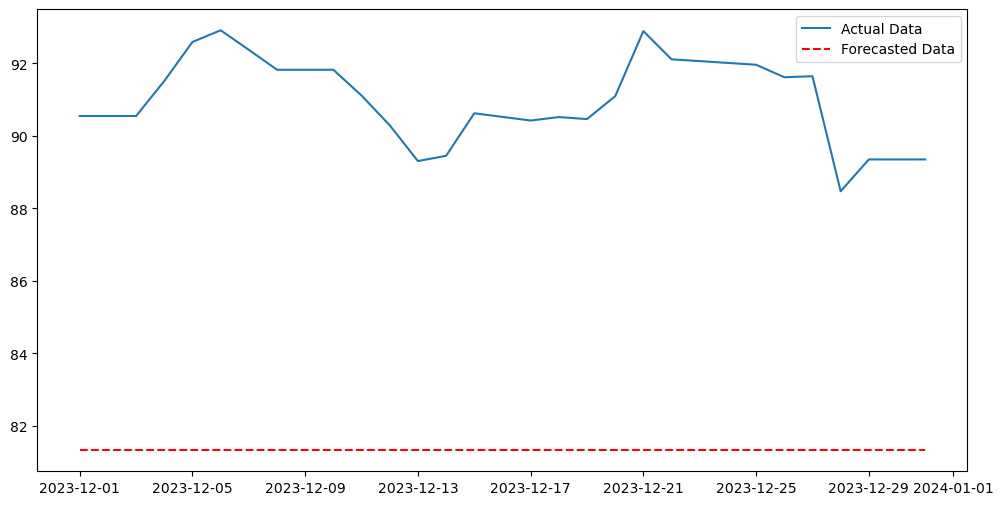

Test RMSE:  9.744459881207382
MAPE:  0.10613610127552014


In [66]:
plt.figure(figsize=(12,6))
plt.plot(ydata['Курс']['2023-12-01':], label='Actual Data')
plt.plot(forecast.mean[split_date:], label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
print('Test RMSE: ', sqrt(mean_squared_error(ydata['Курс']['2023-12-01':], forecast.mean[split_date:])))
print('MAPE: ', mape(ydata['Курс']['2023-12-01':], forecast.mean[split_date:]))

<Axes: xlabel='Дата'>

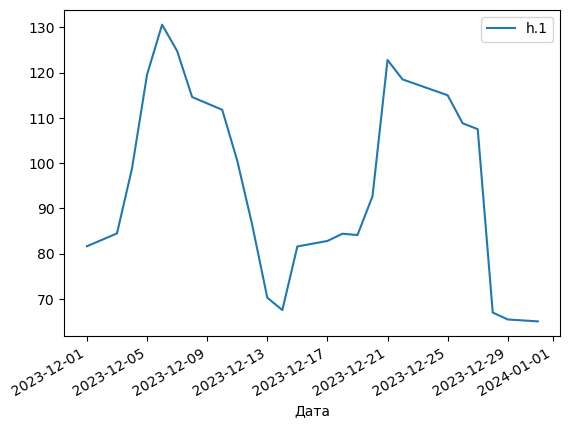

In [67]:
forecast.variance[split_date:].plot()

### GARCH 2016-2021

In [68]:
p = range(1, 15)
q = range(1, 15)

min_aic = np.inf
for i in p:
    for j in q:
        model = arch_model(data_new['Курс'], vol='GARCH', p=i, q=j).fit()
        aic = model.aic
        if aic < min_aic:
            min_aic = aic
            best_arch = (i, j)

print('Оптимальные параметры модели GARCH:')
print('p:', best_arch[0])
print('q:', best_arch[1])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 242.5945973919566
Iteration:      2,   Func. Count:     12,   Neg. LLF: 317.25567965878724
Iteration:      3,   Func. Count:     18,   Neg. LLF: 218.87065501628993
Iteration:      4,   Func. Count:     24,   Neg. LLF: 215.3018615759487
Iteration:      5,   Func. Count:     29,   Neg. LLF: 215.07788688505786
Iteration:      6,   Func. Count:     35,   Neg. LLF: 213.1953280525877
Iteration:      7,   Func. Count:     40,   Neg. LLF: 212.47278962597233
Iteration:      8,   Func. Count:     45,   Neg. LLF: 212.25207465815714
Iteration:      9,   Func. Count:     50,   Neg. LLF: 212.21384156109897
Iteration:     10,   Func. Count:     55,   Neg. LLF: 212.208827635666
Iteration:     11,   Func. Count:     60,   Neg. LLF: 212.20844463160586
Iteration:     12,   Func. Count:     65,   Neg. LLF: 212.20844116951727
Iteration:     13,   Func. Count:     69,   Neg. LLF: 212.20844111315196
Optimization terminated successfully    (Exit mode 0)
  

Iteration:      1,   Func. Count:     12,   Neg. LLF: 219.34143591730634
Iteration:      2,   Func. Count:     23,   Neg. LLF: 221.37451163218878
Iteration:      3,   Func. Count:     35,   Neg. LLF: 218.26247852085882
Iteration:      4,   Func. Count:     46,   Neg. LLF: 215.0408358349264
Iteration:      5,   Func. Count:     57,   Neg. LLF: 231.42017180757463
Iteration:      6,   Func. Count:     69,   Neg. LLF: 227.26598672965525
Iteration:      7,   Func. Count:     81,   Neg. LLF: 223.98873466550833
Iteration:      8,   Func. Count:     93,   Neg. LLF: 226.61883849134693
Iteration:      9,   Func. Count:    105,   Neg. LLF: 222.1749939499528
Iteration:     10,   Func. Count:    117,   Neg. LLF: 220.6576441043864
Iteration:     11,   Func. Count:    129,   Neg. LLF: 219.78341986778264
Iteration:     12,   Func. Count:    141,   Neg. LLF: 219.26746689199234
Iteration:     13,   Func. Count:    153,   Neg. LLF: 216.08391497973926
Iteration:     14,   Func. Count:    165,   Neg. LLF: 

Iteration:      6,   Func. Count:     91,   Neg. LLF: 218.41310648357094
Iteration:      7,   Func. Count:    106,   Neg. LLF: 225.21743946630056
Iteration:      8,   Func. Count:    122,   Neg. LLF: 265.19741613875885
Iteration:      9,   Func. Count:    138,   Neg. LLF: 250.723434289433
Iteration:     10,   Func. Count:    154,   Neg. LLF: 238.51296348537107
Iteration:     11,   Func. Count:    170,   Neg. LLF: 235.1830572511269
Iteration:     12,   Func. Count:    186,   Neg. LLF: 227.6629806313391
Iteration:     13,   Func. Count:    202,   Neg. LLF: 227.356654909436
Iteration:     14,   Func. Count:    218,   Neg. LLF: 239.94458011482044
Iteration:     15,   Func. Count:    234,   Neg. LLF: 225.78526128851144
Iteration:     16,   Func. Count:    250,   Neg. LLF: 229.95613200693015
Iteration:     17,   Func. Count:    266,   Neg. LLF: 221.54779331098808
Iteration:     18,   Func. Count:    282,   Neg. LLF: 222.4512891483103
Iteration:     19,   Func. Count:    298,   Neg. LLF: 214.

Iteration:      1,   Func. Count:     10,   Neg. LLF: 219.40824036629004
Iteration:      2,   Func. Count:     19,   Neg. LLF: 220.6721070886371
Iteration:      3,   Func. Count:     29,   Neg. LLF: 217.894330247523
Iteration:      4,   Func. Count:     38,   Neg. LLF: 217.15369547403566
Iteration:      5,   Func. Count:     47,   Neg. LLF: 214.8327823971944
Iteration:      6,   Func. Count:     56,   Neg. LLF: 238.6908073506296
Iteration:      7,   Func. Count:     66,   Neg. LLF: 236.5350350509134
Iteration:      8,   Func. Count:     76,   Neg. LLF: 232.14165476423614
Iteration:      9,   Func. Count:     86,   Neg. LLF: 231.3189126444516
Iteration:     10,   Func. Count:     96,   Neg. LLF: 230.68557451280543
Iteration:     11,   Func. Count:    106,   Neg. LLF: 229.76880355532717
Iteration:     12,   Func. Count:    116,   Neg. LLF: 231.67492786141847
Iteration:     13,   Func. Count:    126,   Neg. LLF: 216.73408545767296
Iteration:     14,   Func. Count:    136,   Neg. LLF: 212.

Iteration:      1,   Func. Count:     15,   Neg. LLF: 224.82557752252094
Iteration:      2,   Func. Count:     29,   Neg. LLF: 224.06212604766023
Iteration:      3,   Func. Count:     43,   Neg. LLF: 222.95200734902897
Iteration:      4,   Func. Count:     57,   Neg. LLF: 222.56548133465228
Iteration:      5,   Func. Count:     71,   Neg. LLF: 221.6122889431515
Iteration:      6,   Func. Count:     85,   Neg. LLF: 220.31324443418458
Iteration:      7,   Func. Count:     99,   Neg. LLF: 213.9256618072227
Iteration:      8,   Func. Count:    113,   Neg. LLF: 236.22242891623546
Iteration:      9,   Func. Count:    128,   Neg. LLF: 236.14387830431008
Iteration:     10,   Func. Count:    146,   Neg. LLF: 219.6305830892235
Iteration:     11,   Func. Count:    161,   Neg. LLF: 215.0984899032402
Iteration:     12,   Func. Count:    176,   Neg. LLF: 211.56222304694472
Iteration:     13,   Func. Count:    191,   Neg. LLF: 214.81812452759593
Iteration:     14,   Func. Count:    206,   Neg. LLF: 2

Iteration:     21,   Func. Count:    390,   Neg. LLF: 211.02395148260402
Iteration:     22,   Func. Count:    408,   Neg. LLF: 211.02393427166285
Iteration:     23,   Func. Count:    426,   Neg. LLF: 211.02392884119877
Iteration:     24,   Func. Count:    443,   Neg. LLF: 211.02392989023448
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.02392884119877
            Iterations: 25
            Function evaluations: 443
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     20,   Neg. LLF: 224.84130924531155
Iteration:      2,   Func. Count:     39,   Neg. LLF: 224.11865848563528
Iteration:      3,   Func. Count:     58,   Neg. LLF: 223.0343194129655
Iteration:      4,   Func. Count:     77,   Neg. LLF: 222.78685506975626
Iteration:      5,   Func. Count:     96,   Neg. LLF: 221.68200640579934
Iteration:      6,   Func. Count:    115,   Neg. LLF: 220.7621561292016
Iteration:      7,   Func. Count:    134,   Neg. LLF: 215.244

Iteration:     21,   Func. Count:    245,   Neg. LLF: 211.26357737910152
Iteration:     22,   Func. Count:    256,   Neg. LLF: 211.26278793468404
Iteration:     23,   Func. Count:    267,   Neg. LLF: 211.2627841979268
Iteration:     24,   Func. Count:    278,   Neg. LLF: 211.26278335597124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.26278335597124
            Iterations: 24
            Function evaluations: 278
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     13,   Neg. LLF: 224.88353343205108
Iteration:      2,   Func. Count:     25,   Neg. LLF: 224.01700636166015
Iteration:      3,   Func. Count:     37,   Neg. LLF: 222.9457019601661
Iteration:      4,   Func. Count:     49,   Neg. LLF: 222.6154605448925
Iteration:      5,   Func. Count:     61,   Neg. LLF: 221.61515756220558
Iteration:      6,   Func. Count:     73,   Neg. LLF: 220.430988547117
Iteration:      7,   Func. Count:     85,   Neg. LLF: 213.731000

Iteration:      7,   Func. Count:    114,   Neg. LLF: 304.419738740464
Iteration:      8,   Func. Count:    131,   Neg. LLF: 227.52350440713613
Iteration:      9,   Func. Count:    148,   Neg. LLF: 231.75212052312364
Iteration:     10,   Func. Count:    165,   Neg. LLF: 227.0738342440617
Iteration:     11,   Func. Count:    182,   Neg. LLF: 228.1073745192889
Iteration:     12,   Func. Count:    199,   Neg. LLF: 225.94394258483294
Iteration:     13,   Func. Count:    216,   Neg. LLF: 246.25295348236727
Iteration:     14,   Func. Count:    233,   Neg. LLF: 226.47587795802082
Iteration:     15,   Func. Count:    250,   Neg. LLF: 215.6016447686661
Iteration:     16,   Func. Count:    267,   Neg. LLF: 214.7308166911636
Iteration:     17,   Func. Count:    284,   Neg. LLF: 211.81553984826553
Iteration:     18,   Func. Count:    301,   Neg. LLF: 214.18392567606548
Iteration:     19,   Func. Count:    318,   Neg. LLF: 211.94148105805857
Iteration:     20,   Func. Count:    335,   Neg. LLF: 211

Iteration:     21,   Func. Count:    437,   Neg. LLF: 226.58608158103883
Iteration:     22,   Func. Count:    458,   Neg. LLF: 224.72087136198323
Iteration:     23,   Func. Count:    479,   Neg. LLF: 214.41635085290955
Iteration:     24,   Func. Count:    500,   Neg. LLF: 221.32184903884342
Iteration:     25,   Func. Count:    521,   Neg. LLF: 213.80298764570378
Iteration:     26,   Func. Count:    542,   Neg. LLF: 222.31497650441582
Iteration:     27,   Func. Count:    563,   Neg. LLF: 213.69040195085313
Iteration:     28,   Func. Count:    584,   Neg. LLF: 234.05573712814737
Iteration:     29,   Func. Count:    605,   Neg. LLF: 211.6723090484074
Iteration:     30,   Func. Count:    626,   Neg. LLF: 211.25693841115395
Iteration:     31,   Func. Count:    647,   Neg. LLF: 211.02629937655007
Iteration:     32,   Func. Count:    667,   Neg. LLF: 211.0239684973946
Iteration:     33,   Func. Count:    687,   Neg. LLF: 211.02393245618373
Iteration:     34,   Func. Count:    707,   Neg. LLF:

Iteration:     10,   Func. Count:    123,   Neg. LLF: 220.86568105997182
Iteration:     11,   Func. Count:    136,   Neg. LLF: 222.3971171137282
Iteration:     12,   Func. Count:    149,   Neg. LLF: 432.8949457796059
Iteration:     13,   Func. Count:    162,   Neg. LLF: 223.29400332481964
Iteration:     14,   Func. Count:    175,   Neg. LLF: 221.29431576283892
Iteration:     15,   Func. Count:    188,   Neg. LLF: 225.92646273866637
Iteration:     16,   Func. Count:    201,   Neg. LLF: 228.55871546192913
Iteration:     17,   Func. Count:    215,   Neg. LLF: 213.30579540540126
Iteration:     18,   Func. Count:    228,   Neg. LLF: 211.47244155921032
Iteration:     19,   Func. Count:    240,   Neg. LLF: 211.38055851394859
Iteration:     20,   Func. Count:    252,   Neg. LLF: 211.32132572552496
Iteration:     21,   Func. Count:    264,   Neg. LLF: 211.26512437263082
Iteration:     22,   Func. Count:    276,   Neg. LLF: 211.2628602701122
Iteration:     23,   Func. Count:    288,   Neg. LLF: 

Iteration:     18,   Func. Count:    300,   Neg. LLF: 211.02405727386872
Iteration:     19,   Func. Count:    316,   Neg. LLF: 211.02392928526905
Iteration:     20,   Func. Count:    331,   Neg. LLF: 211.0239293970834
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.02392928526905
            Iterations: 20
            Function evaluations: 331
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     18,   Neg. LLF: 224.93590484430632
Iteration:      2,   Func. Count:     35,   Neg. LLF: 224.08549489884444
Iteration:      3,   Func. Count:     52,   Neg. LLF: 223.06106501257912
Iteration:      4,   Func. Count:     69,   Neg. LLF: 223.0460791333316
Iteration:      5,   Func. Count:     87,   Neg. LLF: 221.5891070737891
Iteration:      6,   Func. Count:    104,   Neg. LLF: 216.5269881750152
Iteration:      7,   Func. Count:    121,   Neg. LLF: 230.21134003588483
Iteration:      8,   Func. Count:    139,   Neg. LLF: 226.79640

Iteration:     12,   Func. Count:    247,   Neg. LLF: 211.67668023815878
Iteration:     13,   Func. Count:    267,   Neg. LLF: 288.1674394271449
Iteration:     14,   Func. Count:    288,   Neg. LLF: 264.1169251578608
Iteration:     15,   Func. Count:    310,   Neg. LLF: 214.20925977302136
Iteration:     16,   Func. Count:    331,   Neg. LLF: 218.89416366017554
Iteration:     17,   Func. Count:    352,   Neg. LLF: 212.06129963272878
Iteration:     18,   Func. Count:    373,   Neg. LLF: 211.0272547465198
Iteration:     19,   Func. Count:    393,   Neg. LLF: 211.02541973772782
Iteration:     20,   Func. Count:    413,   Neg. LLF: 211.02453649499648
Iteration:     21,   Func. Count:    433,   Neg. LLF: 211.02393337234938
Iteration:     22,   Func. Count:    453,   Neg. LLF: 211.02392913526594
Iteration:     23,   Func. Count:    472,   Neg. LLF: 211.02393018415273
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.02392913526594
            Iterat

Iteration:      2,   Func. Count:     25,   Neg. LLF: 224.03978762968597
Iteration:      3,   Func. Count:     37,   Neg. LLF: 223.00008018634736
Iteration:      4,   Func. Count:     49,   Neg. LLF: 222.75109204257137
Iteration:      5,   Func. Count:     61,   Neg. LLF: 221.66639987202677
Iteration:      6,   Func. Count:     73,   Neg. LLF: 220.71257383083912
Iteration:      7,   Func. Count:     85,   Neg. LLF: 214.94938515245673
Iteration:      8,   Func. Count:     97,   Neg. LLF: 227.08098995744402
Iteration:      9,   Func. Count:    110,   Neg. LLF: 225.8200456235411
Iteration:     10,   Func. Count:    123,   Neg. LLF: 225.7547987847655
Iteration:     11,   Func. Count:    136,   Neg. LLF: 221.9443628152671
Iteration:     12,   Func. Count:    149,   Neg. LLF: 212.12515009970144
Iteration:     13,   Func. Count:    161,   Neg. LLF: 226.5458273368542
Iteration:     14,   Func. Count:    174,   Neg. LLF: 227.84891143004256
Iteration:     15,   Func. Count:    187,   Neg. LLF: 2

Iteration:     15,   Func. Count:    249,   Neg. LLF: 216.07034720977418
Iteration:     16,   Func. Count:    266,   Neg. LLF: 227.87811351007477
Iteration:     17,   Func. Count:    283,   Neg. LLF: 214.65911140744007
Iteration:     18,   Func. Count:    300,   Neg. LLF: 214.46285050570327
Iteration:     19,   Func. Count:    317,   Neg. LLF: 211.5024582210251
Iteration:     20,   Func. Count:    334,   Neg. LLF: 211.04900436672574
Iteration:     21,   Func. Count:    351,   Neg. LLF: 211.0248580371288
Iteration:     22,   Func. Count:    367,   Neg. LLF: 211.0239302780817
Iteration:     23,   Func. Count:    383,   Neg. LLF: 211.02392870010829
Iteration:     24,   Func. Count:    398,   Neg. LLF: 211.02392861495784
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.02392870010829
            Iterations: 25
            Function evaluations: 398
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     18,   Neg. LLF: 224.9352

Iteration:     20,   Func. Count:    414,   Neg. LLF: 211.25897877371278
Iteration:     21,   Func. Count:    435,   Neg. LLF: 211.18321660600975
Iteration:     22,   Func. Count:    455,   Neg. LLF: 211.12316296783388
Iteration:     23,   Func. Count:    475,   Neg. LLF: 211.06762355791284
Iteration:     24,   Func. Count:    495,   Neg. LLF: 211.03432093890245
Iteration:     25,   Func. Count:    515,   Neg. LLF: 211.02444356812276
Iteration:     26,   Func. Count:    535,   Neg. LLF: 211.02394031681757
Iteration:     27,   Func. Count:    555,   Neg. LLF: 211.02392989747457
Iteration:     28,   Func. Count:    575,   Neg. LLF: 211.02392877961535
Iteration:     29,   Func. Count:    594,   Neg. LLF: 211.02392980156355
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.02392877961535
            Iterations: 29
            Function evaluations: 594
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     22,   Neg. LLF: 224.9

Iteration:      2,   Func. Count:     27,   Neg. LLF: 224.06812907080584
Iteration:      3,   Func. Count:     40,   Neg. LLF: 223.04089778418887
Iteration:      4,   Func. Count:     53,   Neg. LLF: 222.85052486786265
Iteration:      5,   Func. Count:     67,   Neg. LLF: 221.5793899613783
Iteration:      6,   Func. Count:     80,   Neg. LLF: 215.82652602943244
Iteration:      7,   Func. Count:     93,   Neg. LLF: 434.43334399045386
Iteration:      8,   Func. Count:    107,   Neg. LLF: 233.13924140265354
Iteration:      9,   Func. Count:    121,   Neg. LLF: 228.31327981832288
Iteration:     10,   Func. Count:    135,   Neg. LLF: 228.10638717711936
Iteration:     11,   Func. Count:    149,   Neg. LLF: 227.22698127197214
Iteration:     12,   Func. Count:    163,   Neg. LLF: 226.78057548408913
Iteration:     13,   Func. Count:    177,   Neg. LLF: 225.97207628262117
Iteration:     14,   Func. Count:    191,   Neg. LLF: 226.09998600677778
Iteration:     15,   Func. Count:    205,   Neg. LLF

Iteration:     23,   Func. Count:    408,   Neg. LLF: 211.04648600079594
Iteration:     24,   Func. Count:    425,   Neg. LLF: 211.02751522449884
Iteration:     25,   Func. Count:    442,   Neg. LLF: 211.02395191277193
Iteration:     26,   Func. Count:    459,   Neg. LLF: 211.02394931010798
Iteration:     27,   Func. Count:    477,   Neg. LLF: 211.0239290993238
Iteration:     28,   Func. Count:    493,   Neg. LLF: 211.02392901428016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.0239290993238
            Iterations: 28
            Function evaluations: 493
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     19,   Neg. LLF: 224.93622714667615
Iteration:      2,   Func. Count:     37,   Neg. LLF: 224.1237761836465
Iteration:      3,   Func. Count:     55,   Neg. LLF: 223.1215222189103
Iteration:      4,   Func. Count:     73,   Neg. LLF: 223.16468433499793
Iteration:      5,   Func. Count:     92,   Neg. LLF: 221.59692

Iteration:     10,   Func. Count:    215,   Neg. LLF: 223.7622586518027
Iteration:     11,   Func. Count:    237,   Neg. LLF: 222.3640714276874
Iteration:     12,   Func. Count:    259,   Neg. LLF: 221.4870261449987
Iteration:     13,   Func. Count:    281,   Neg. LLF: 221.12855590344776
Iteration:     14,   Func. Count:    303,   Neg. LLF: 216.51659948121954
Iteration:     15,   Func. Count:    325,   Neg. LLF: 222.49834477828426
Iteration:     16,   Func. Count:    347,   Neg. LLF: 214.4059632649375
Iteration:     17,   Func. Count:    369,   Neg. LLF: 212.0533922652275
Iteration:     18,   Func. Count:    391,   Neg. LLF: 213.76499069574555
Iteration:     19,   Func. Count:    413,   Neg. LLF: 211.2382113163759
Iteration:     20,   Func. Count:    434,   Neg. LLF: 211.14013272518696
Iteration:     21,   Func. Count:    455,   Neg. LLF: 211.02862401764816
Iteration:     22,   Func. Count:    476,   Neg. LLF: 211.0240957882545
Iteration:     23,   Func. Count:    497,   Neg. LLF: 211.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 224.91486484572113
Iteration:      2,   Func. Count:     27,   Neg. LLF: 224.08160090416135
Iteration:      3,   Func. Count:     40,   Neg. LLF: 223.06464906029146
Iteration:      4,   Func. Count:     53,   Neg. LLF: 222.91073754946703
Iteration:      5,   Func. Count:     67,   Neg. LLF: 221.58521220785684
Iteration:      6,   Func. Count:     80,   Neg. LLF: 215.82857820276894
Iteration:      7,   Func. Count:     93,   Neg. LLF: 7407.9359611000855
Iteration:      8,   Func. Count:    107,   Neg. LLF: 235.6524316178038
Iteration:      9,   Func. Count:    121,   Neg. LLF: 227.2380449027234
Iteration:     10,   Func. Count:    135,   Neg. LLF: 227.1126220717121
Iteration:     11,   Func. Count:    149,   Neg. LLF: 225.742592532733
Iteration:     12,   Func. Count:    163,   Neg. LLF: 225.85175802894497
Iteration:     13,   Func. Count:    177,   Neg. LLF: 226.4227992483266
Iteration:     14,   Func. Count:    192,   Neg. LLF: 278

Iteration:     33,   Func. Count:    587,   Neg. LLF: 211.06396628682944
Iteration:     34,   Func. Count:    603,   Neg. LLF: 211.06396620649934
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.06396628682944
            Iterations: 34
            Function evaluations: 603
            Gradient evaluations: 34
Iteration:      1,   Func. Count:     19,   Neg. LLF: 224.94245464987137
Iteration:      2,   Func. Count:     37,   Neg. LLF: 224.13971804273683
Iteration:      3,   Func. Count:     55,   Neg. LLF: 223.14698777737559
Iteration:      4,   Func. Count:     73,   Neg. LLF: 223.21124063731688
Iteration:      5,   Func. Count:     92,   Neg. LLF: 221.60084400201333
Iteration:      6,   Func. Count:    110,   Neg. LLF: 222.06859050881678
Iteration:      7,   Func. Count:    129,   Neg. LLF: 342.73055500418053
Iteration:      8,   Func. Count:    148,   Neg. LLF: 301.05482246342507
Iteration:      9,   Func. Count:    167,   Neg. LLF: 437.3

Iteration:      6,   Func. Count:    134,   Neg. LLF: 218.43421156503894
Iteration:      7,   Func. Count:    156,   Neg. LLF: 240.03639244206283
Iteration:      8,   Func. Count:    179,   Neg. LLF: 337.7737202414146
Iteration:      9,   Func. Count:    202,   Neg. LLF: 230.92057027880412
Iteration:     10,   Func. Count:    225,   Neg. LLF: 282.6389169296179
Iteration:     11,   Func. Count:    248,   Neg. LLF: 228.0191845422255
Iteration:     12,   Func. Count:    271,   Neg. LLF: 216.17437688350367
Iteration:     13,   Func. Count:    294,   Neg. LLF: 214.15717601135128
Iteration:     14,   Func. Count:    317,   Neg. LLF: 226.55643094716598
Iteration:     15,   Func. Count:    340,   Neg. LLF: 211.93847285364996
Iteration:     16,   Func. Count:    363,   Neg. LLF: 211.48607117633404
Iteration:     17,   Func. Count:    385,   Neg. LLF: 211.89057066185867
Iteration:     18,   Func. Count:    408,   Neg. LLF: 212.40768991017842
Iteration:     19,   Func. Count:    431,   Neg. LLF: 

Iteration:     13,   Func. Count:    177,   Neg. LLF: 222.48567468801429
Iteration:     14,   Func. Count:    191,   Neg. LLF: 238.56957273092877
Iteration:     15,   Func. Count:    205,   Neg. LLF: 222.6441253319154
Iteration:     16,   Func. Count:    219,   Neg. LLF: 215.24381744490893
Iteration:     17,   Func. Count:    233,   Neg. LLF: 212.67737995629756
Iteration:     18,   Func. Count:    247,   Neg. LLF: 215.0228882672571
Iteration:     19,   Func. Count:    261,   Neg. LLF: 211.36399980435695
Iteration:     20,   Func. Count:    274,   Neg. LLF: 238.29378073702506
Iteration:     21,   Func. Count:    288,   Neg. LLF: 211.19798145347062
Iteration:     22,   Func. Count:    301,   Neg. LLF: 211.15797587790962
Iteration:     23,   Func. Count:    314,   Neg. LLF: 211.1312599036542
Iteration:     24,   Func. Count:    327,   Neg. LLF: 211.12867769848904
Iteration:     25,   Func. Count:    340,   Neg. LLF: 211.1285073993606
Iteration:     26,   Func. Count:    352,   Neg. LLF: 2

Iteration:     24,   Func. Count:    425,   Neg. LLF: 211.12853907387856
Iteration:     25,   Func. Count:    442,   Neg. LLF: 211.1285092292155
Iteration:     26,   Func. Count:    459,   Neg. LLF: 211.1285069537595
Iteration:     27,   Func. Count:    475,   Neg. LLF: 211.1285076407234
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.1285069537595
            Iterations: 28
            Function evaluations: 475
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     19,   Neg. LLF: 224.96734395785217
Iteration:      2,   Func. Count:     37,   Neg. LLF: 224.150961941476
Iteration:      3,   Func. Count:     55,   Neg. LLF: 223.17301024771515
Iteration:      4,   Func. Count:     73,   Neg. LLF: 223.32944347782345
Iteration:      5,   Func. Count:     92,   Neg. LLF: 221.6039131772901
Iteration:      6,   Func. Count:    110,   Neg. LLF: 218.68981969555722
Iteration:      7,   Func. Count:    128,   Neg. LLF: 237.55515384

Iteration:     12,   Func. Count:    271,   Neg. LLF: 225.85267561596277
Iteration:     13,   Func. Count:    294,   Neg. LLF: 215.9259965176171
Iteration:     14,   Func. Count:    317,   Neg. LLF: 214.39154778591373
Iteration:     15,   Func. Count:    340,   Neg. LLF: 214.96181390059706
Iteration:     16,   Func. Count:    363,   Neg. LLF: 214.08030376892344
Iteration:     17,   Func. Count:    386,   Neg. LLF: 216.06631842587538
Iteration:     18,   Func. Count:    409,   Neg. LLF: 211.30966275072694
Iteration:     19,   Func. Count:    431,   Neg. LLF: 211.15934747995453
Iteration:     20,   Func. Count:    453,   Neg. LLF: 211.05715466090837
Iteration:     21,   Func. Count:    475,   Neg. LLF: 211.02778275529988
Iteration:     22,   Func. Count:    497,   Neg. LLF: 211.02443625637613
Iteration:     23,   Func. Count:    519,   Neg. LLF: 211.02394244570036
Iteration:     24,   Func. Count:    541,   Neg. LLF: 211.0239292045266
Iteration:     25,   Func. Count:    563,   Neg. LLF:

Iteration:     18,   Func. Count:    246,   Neg. LLF: 210.93345324733195
Iteration:     19,   Func. Count:    259,   Neg. LLF: 210.9334406081975
Iteration:     20,   Func. Count:    272,   Neg. LLF: 210.93343990544872
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.93343990544872
            Iterations: 20
            Function evaluations: 272
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     15,   Neg. LLF: 224.9822405434307
Iteration:      2,   Func. Count:     29,   Neg. LLF: 224.11004424093227
Iteration:      3,   Func. Count:     43,   Neg. LLF: 223.13256860537268
Iteration:      4,   Func. Count:     57,   Neg. LLF: 223.23658010136177
Iteration:      5,   Func. Count:     72,   Neg. LLF: 221.5966935896209
Iteration:      6,   Func. Count:     86,   Neg. LLF: 219.59521233840604
Iteration:      7,   Func. Count:    100,   Neg. LLF: 217.81535633041375
Iteration:      8,   Func. Count:    114,   Neg. LLF: 221.7902

Iteration:     13,   Func. Count:    242,   Neg. LLF: 226.90062913233152
Iteration:     14,   Func. Count:    261,   Neg. LLF: 215.1155447496302
Iteration:     15,   Func. Count:    280,   Neg. LLF: 213.84423554322598
Iteration:     16,   Func. Count:    299,   Neg. LLF: 214.83605460041966
Iteration:     17,   Func. Count:    318,   Neg. LLF: 211.07459753758934
Iteration:     18,   Func. Count:    336,   Neg. LLF: 212.40629496044352
Iteration:     19,   Func. Count:    355,   Neg. LLF: 210.97147015498692
Iteration:     20,   Func. Count:    373,   Neg. LLF: 210.93513705136527
Iteration:     21,   Func. Count:    391,   Neg. LLF: 210.93352189183037
Iteration:     22,   Func. Count:    409,   Neg. LLF: 210.93345297361782
Iteration:     23,   Func. Count:    427,   Neg. LLF: 210.9334393440281
Iteration:     24,   Func. Count:    445,   Neg. LLF: 211.13753008904837
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.93343934061852
            Itera

Iteration:     20,   Func. Count:    456,   Neg. LLF: 210.97125147177815
Iteration:     21,   Func. Count:    478,   Neg. LLF: 210.94024843682547
Iteration:     22,   Func. Count:    500,   Neg. LLF: 210.93631787994906
Iteration:     23,   Func. Count:    522,   Neg. LLF: 210.93410551917398
Iteration:     24,   Func. Count:    544,   Neg. LLF: 210.93369557015797
Iteration:     25,   Func. Count:    566,   Neg. LLF: 210.93344803018292
Iteration:     26,   Func. Count:    588,   Neg. LLF: 210.93344024266744
Iteration:     27,   Func. Count:    609,   Neg. LLF: 210.93344022950018
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.93344024266744
            Iterations: 27
            Function evaluations: 609
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     24,   Neg. LLF: 225.0357109894366
Iteration:      2,   Func. Count:     47,   Neg. LLF: 224.19048164797522
Iteration:      3,   Func. Count:     70,   Neg. LLF: 223.25

Iteration:     19,   Func. Count:    507,   Neg. LLF: 225.7108293686025
Iteration:     20,   Func. Count:    534,   Neg. LLF: 215.26081877725895
Iteration:     21,   Func. Count:    561,   Neg. LLF: 215.3901447024058
Iteration:     22,   Func. Count:    588,   Neg. LLF: 215.08585239914413
Iteration:     23,   Func. Count:    615,   Neg. LLF: 211.41432951309542
Iteration:     24,   Func. Count:    642,   Neg. LLF: 210.95382223329347
Iteration:     25,   Func. Count:    668,   Neg. LLF: 210.94003512023323
Iteration:     26,   Func. Count:    694,   Neg. LLF: 210.93551480901388
Iteration:     27,   Func. Count:    720,   Neg. LLF: 210.93388079734854
Iteration:     28,   Func. Count:    746,   Neg. LLF: 210.93346112769842
Iteration:     29,   Func. Count:    772,   Neg. LLF: 210.93344440703515
Iteration:     30,   Func. Count:    798,   Neg. LLF: 210.9334403569686
Iteration:     31,   Func. Count:    823,   Neg. LLF: 210.93344121818552
Optimization terminated successfully    (Exit mode 0)


Iteration:     23,   Func. Count:    405,   Neg. LLF: 210.93344776559934
Iteration:     24,   Func. Count:    422,   Neg. LLF: 210.93343910814633
Iteration:     25,   Func. Count:    439,   Neg. LLF: 210.93343960763752
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.93343910930108
            Iterations: 25
            Function evaluations: 449
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     19,   Neg. LLF: 225.0275933922665
Iteration:      2,   Func. Count:     37,   Neg. LLF: 224.16788302573116
Iteration:      3,   Func. Count:     55,   Neg. LLF: 223.21976519302422
Iteration:      4,   Func. Count:     73,   Neg. LLF: 223.62626819517254
Iteration:      5,   Func. Count:     92,   Neg. LLF: 221.60846889097016
Iteration:      6,   Func. Count:    110,   Neg. LLF: 218.79078385220032
Iteration:      7,   Func. Count:    128,   Neg. LLF: 833.2622673880173
Iteration:      8,   Func. Count:    147,   Neg. LLF: 787.866

Iteration:     19,   Func. Count:    413,   Neg. LLF: 215.06067429216387
Iteration:     20,   Func. Count:    435,   Neg. LLF: 216.45137326082573
Iteration:     21,   Func. Count:    458,   Neg. LLF: 211.01918403574246
Iteration:     22,   Func. Count:    479,   Neg. LLF: 210.9502049967378
Iteration:     23,   Func. Count:    500,   Neg. LLF: 210.9363703177084
Iteration:     24,   Func. Count:    521,   Neg. LLF: 210.93905342211073
Iteration:     25,   Func. Count:    543,   Neg. LLF: 210.93352028642823
Iteration:     26,   Func. Count:    564,   Neg. LLF: 210.9334400415233
Iteration:     27,   Func. Count:    584,   Neg. LLF: 210.93344007367406
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.9334400415233
            Iterations: 27
            Function evaluations: 584
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     23,   Neg. LLF: 225.06108795422625
Iteration:      2,   Func. Count:     45,   Neg. LLF: 224.19747

Iteration:      9,   Func. Count:    229,   Neg. LLF: 230.70777556219917
Iteration:     10,   Func. Count:    255,   Neg. LLF: 215.40810330990365
Iteration:     11,   Func. Count:    280,   Neg. LLF: 221.35728146792925
Iteration:     12,   Func. Count:    306,   Neg. LLF: 213.40901293269906
Iteration:     13,   Func. Count:    331,   Neg. LLF: 215.74092702411326
Iteration:     14,   Func. Count:    357,   Neg. LLF: 227.85625218351333
Iteration:     15,   Func. Count:    383,   Neg. LLF: 228.48304198943788
Iteration:     16,   Func. Count:    409,   Neg. LLF: 222.15106070774058
Iteration:     17,   Func. Count:    435,   Neg. LLF: 216.20822138914173
Iteration:     18,   Func. Count:    461,   Neg. LLF: 216.15396815207143
Iteration:     19,   Func. Count:    487,   Neg. LLF: 270.2629504750728
Iteration:     20,   Func. Count:    513,   Neg. LLF: 215.3894412793909
Iteration:     21,   Func. Count:    539,   Neg. LLF: 619.1283511803183
Iteration:     22,   Func. Count:    566,   Neg. LLF: 

Iteration:     13,   Func. Count:    216,   Neg. LLF: 225.83162474346926
Iteration:     14,   Func. Count:    233,   Neg. LLF: 214.92364124172911
Iteration:     15,   Func. Count:    250,   Neg. LLF: 218.63577686177138
Iteration:     16,   Func. Count:    267,   Neg. LLF: 214.75408521091848
Iteration:     17,   Func. Count:    284,   Neg. LLF: 219.13237320340235
Iteration:     18,   Func. Count:    301,   Neg. LLF: 215.0566635334846
Iteration:     19,   Func. Count:    318,   Neg. LLF: 211.70593087483255
Iteration:     20,   Func. Count:    335,   Neg. LLF: 215.1787400056934
Iteration:     21,   Func. Count:    352,   Neg. LLF: 214.48629007438984
Iteration:     22,   Func. Count:    369,   Neg. LLF: 210.99818527888306
Iteration:     23,   Func. Count:    385,   Neg. LLF: 210.96799623846354
Iteration:     24,   Func. Count:    401,   Neg. LLF: 210.93250222264155
Iteration:     25,   Func. Count:    417,   Neg. LLF: 210.92370959210916
Iteration:     26,   Func. Count:    433,   Neg. LLF:

Iteration:     14,   Func. Count:    289,   Neg. LLF: 223.93560029729963
Iteration:     15,   Func. Count:    310,   Neg. LLF: 216.31089840688816
Iteration:     16,   Func. Count:    331,   Neg. LLF: 215.98766679811303
Iteration:     17,   Func. Count:    352,   Neg. LLF: 212.19488421014165
Iteration:     18,   Func. Count:    373,   Neg. LLF: 215.0209369411931
Iteration:     19,   Func. Count:    394,   Neg. LLF: 234.17485704734003
Iteration:     20,   Func. Count:    416,   Neg. LLF: 214.55878756782045
Iteration:     21,   Func. Count:    437,   Neg. LLF: 231.80758447790174
Iteration:     22,   Func. Count:    458,   Neg. LLF: 211.43086956804416
Iteration:     23,   Func. Count:    479,   Neg. LLF: 217.90444657487757
Iteration:     24,   Func. Count:    500,   Neg. LLF: 210.92584914224088
Iteration:     25,   Func. Count:    520,   Neg. LLF: 210.9210900088811
Iteration:     26,   Func. Count:    540,   Neg. LLF: 210.92062477831678
Iteration:     27,   Func. Count:    560,   Neg. LLF:

Iteration:     10,   Func. Count:    245,   Neg. LLF: 216.21671998411398
Iteration:     11,   Func. Count:    269,   Neg. LLF: 215.7974467171895
Iteration:     12,   Func. Count:    293,   Neg. LLF: 227.6994309577334
Iteration:     13,   Func. Count:    318,   Neg. LLF: 235.67689896192275
Iteration:     14,   Func. Count:    343,   Neg. LLF: 249.98668397644082
Iteration:     15,   Func. Count:    368,   Neg. LLF: 266.2387207401577
Iteration:     16,   Func. Count:    393,   Neg. LLF: 282.34754364825835
Iteration:     17,   Func. Count:    418,   Neg. LLF: 288.94264385872907
Iteration:     18,   Func. Count:    443,   Neg. LLF: 268.9722294073053
Iteration:     19,   Func. Count:    468,   Neg. LLF: 256.3293692234032
Iteration:     20,   Func. Count:    493,   Neg. LLF: 237.58172289798725
Iteration:     21,   Func. Count:    518,   Neg. LLF: 216.40078660742535
Iteration:     22,   Func. Count:    543,   Neg. LLF: 226.7743768557283
Iteration:     23,   Func. Count:    568,   Neg. LLF: 215

Iteration:     22,   Func. Count:    609,   Neg. LLF: 216.70358189190762
Iteration:     23,   Func. Count:    637,   Neg. LLF: 224.55625409600373
Iteration:     24,   Func. Count:    665,   Neg. LLF: 215.38509012139883
Iteration:     25,   Func. Count:    693,   Neg. LLF: 214.71988552813562
Iteration:     26,   Func. Count:    721,   Neg. LLF: 219.55467713743838
Iteration:     27,   Func. Count:    749,   Neg. LLF: 215.06908778999954
Iteration:     28,   Func. Count:    777,   Neg. LLF: 215.02893470084604
Iteration:     29,   Func. Count:    805,   Neg. LLF: 210.93347349932787
Iteration:     30,   Func. Count:    832,   Neg. LLF: 210.92488046787525
Iteration:     31,   Func. Count:    859,   Neg. LLF: 210.92167722157367
Iteration:     32,   Func. Count:    886,   Neg. LLF: 210.9206512605594
Iteration:     33,   Func. Count:    913,   Neg. LLF: 210.92061055985164
Iteration:     34,   Func. Count:    940,   Neg. LLF: 210.92060831401926
Iteration:     35,   Func. Count:    966,   Neg. LLF

Iteration:     16,   Func. Count:    299,   Neg. LLF: 219.25249605479198
Iteration:     17,   Func. Count:    318,   Neg. LLF: 215.43618100933747
Iteration:     18,   Func. Count:    337,   Neg. LLF: 215.97292528111012
Iteration:     19,   Func. Count:    356,   Neg. LLF: 225.25566879182026
Iteration:     20,   Func. Count:    375,   Neg. LLF: 214.90700989633632
Iteration:     21,   Func. Count:    394,   Neg. LLF: 278.22673524564027
Iteration:     22,   Func. Count:    413,   Neg. LLF: 214.52217488811297
Iteration:     23,   Func. Count:    432,   Neg. LLF: 211.59981461439037
Iteration:     24,   Func. Count:    451,   Neg. LLF: 210.9346165280475
Iteration:     25,   Func. Count:    469,   Neg. LLF: 210.92181403652205
Iteration:     26,   Func. Count:    487,   Neg. LLF: 210.9208078123724
Iteration:     27,   Func. Count:    505,   Neg. LLF: 210.92061598514792
Iteration:     28,   Func. Count:    523,   Neg. LLF: 210.92060874974834
Iteration:     29,   Func. Count:    540,   Neg. LLF:

Iteration:     18,   Func. Count:    407,   Neg. LLF: 210.92108007573518
Iteration:     19,   Func. Count:    429,   Neg. LLF: 210.92075022315032
Iteration:     20,   Func. Count:    451,   Neg. LLF: 210.92060769060726
Iteration:     21,   Func. Count:    473,   Neg. LLF: 211.68494904139303
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.92060751038323
            Iterations: 22
            Function evaluations: 476
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     24,   Neg. LLF: 225.1111263608845
Iteration:      2,   Func. Count:     47,   Neg. LLF: 224.21965236751677
Iteration:      3,   Func. Count:     70,   Neg. LLF: 223.31672046320523
Iteration:      4,   Func. Count:     93,   Neg. LLF: 224.3818777776333
Iteration:      5,   Func. Count:    117,   Neg. LLF: 221.62383261161204
Iteration:      6,   Func. Count:    140,   Neg. LLF: 219.91740529493933
Iteration:      7,   Func. Count:    163,   Neg. LLF: 1132.47

Iteration:      1,   Func. Count:     27,   Neg. LLF: 225.1349265910153
Iteration:      2,   Func. Count:     53,   Neg. LLF: 224.23166630718865
Iteration:      3,   Func. Count:     79,   Neg. LLF: 223.34070762728902
Iteration:      4,   Func. Count:    105,   Neg. LLF: 224.75895059004037
Iteration:      5,   Func. Count:    132,   Neg. LLF: 221.64182442530733
Iteration:      6,   Func. Count:    158,   Neg. LLF: 220.1722166838103
Iteration:      7,   Func. Count:    184,   Neg. LLF: 265.13661804430694
Iteration:      8,   Func. Count:    211,   Neg. LLF: 242.6884841504747
Iteration:      9,   Func. Count:    238,   Neg. LLF: 231.5737853448402
Iteration:     10,   Func. Count:    265,   Neg. LLF: 216.14280484735917
Iteration:     11,   Func. Count:    291,   Neg. LLF: 214.92844597229202
Iteration:     12,   Func. Count:    317,   Neg. LLF: 236.39851750459306
Iteration:     13,   Func. Count:    344,   Neg. LLF: 246.37540773592855
Iteration:     14,   Func. Count:    371,   Neg. LLF: 2

Iteration:     16,   Func. Count:    473,   Neg. LLF: 229.0776932302153
Iteration:     17,   Func. Count:    503,   Neg. LLF: 231.78733397531852
Iteration:     18,   Func. Count:    533,   Neg. LLF: 229.17849471800972
Iteration:     19,   Func. Count:    563,   Neg. LLF: 226.49269400911402
Iteration:     20,   Func. Count:    593,   Neg. LLF: 214.45482760295545
Iteration:     21,   Func. Count:    623,   Neg. LLF: 221.8962679005992
Iteration:     22,   Func. Count:    653,   Neg. LLF: 214.47588860229786
Iteration:     23,   Func. Count:    683,   Neg. LLF: 223.5015142767823
Iteration:     24,   Func. Count:    713,   Neg. LLF: 211.62043456788712
Iteration:     25,   Func. Count:    743,   Neg. LLF: 211.3127067035136
Iteration:     26,   Func. Count:    772,   Neg. LLF: 1204.2647932471637
Iteration:     27,   Func. Count:    802,   Neg. LLF: 214.9875084878357
Iteration:     28,   Func. Count:    832,   Neg. LLF: 211.6491380276429
Iteration:     29,   Func. Count:    862,   Neg. LLF: 210

Iteration:      1,   Func. Count:     21,   Neg. LLF: 225.09187628030077
Iteration:      2,   Func. Count:     41,   Neg. LLF: 224.20261926223742
Iteration:      3,   Func. Count:     61,   Neg. LLF: 223.29013282543843
Iteration:      4,   Func. Count:     81,   Neg. LLF: 224.07861894160618
Iteration:      5,   Func. Count:    102,   Neg. LLF: 221.60373109485377
Iteration:      6,   Func. Count:    122,   Neg. LLF: 219.6088017129384
Iteration:      7,   Func. Count:    142,   Neg. LLF: 817.8654414838923
Iteration:      8,   Func. Count:    163,   Neg. LLF: 390.9819628243157
Iteration:      9,   Func. Count:    184,   Neg. LLF: 248.8541532921681
Iteration:     10,   Func. Count:    205,   Neg. LLF: 226.92124706675392
Iteration:     11,   Func. Count:    226,   Neg. LLF: 226.38724228663563
Iteration:     12,   Func. Count:    247,   Neg. LLF: 224.50979546180446
Iteration:     13,   Func. Count:    268,   Neg. LLF: 224.31729204726946
Iteration:     14,   Func. Count:    289,   Neg. LLF: 2

Iteration:     32,   Func. Count:    758,   Neg. LLF: 210.92061595203558
Iteration:     33,   Func. Count:    781,   Neg. LLF: 210.9206098726238
Iteration:     34,   Func. Count:    804,   Neg. LLF: 210.92060833488065
Iteration:     35,   Func. Count:    826,   Neg. LLF: 210.92060850066713
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.92060833488065
            Iterations: 36
            Function evaluations: 826
            Gradient evaluations: 35
Iteration:      1,   Func. Count:     25,   Neg. LLF: 225.13547337952207
Iteration:      2,   Func. Count:     49,   Neg. LLF: 224.231737977767
Iteration:      3,   Func. Count:     73,   Neg. LLF: 223.34072762443566
Iteration:      4,   Func. Count:     97,   Neg. LLF: 224.60960383291422
Iteration:      5,   Func. Count:    122,   Neg. LLF: 221.6294643042072
Iteration:      6,   Func. Count:    146,   Neg. LLF: 220.09264697738433
Iteration:      7,   Func. Count:    170,   Neg. LLF: 426.53866

Iteration:      7,   Func. Count:    191,   Neg. LLF: 270.0973266448865
Iteration:      8,   Func. Count:    219,   Neg. LLF: 257.66315980096226
Iteration:      9,   Func. Count:    247,   Neg. LLF: 238.9524235832006
Iteration:     10,   Func. Count:    275,   Neg. LLF: 236.49232792661942
Iteration:     11,   Func. Count:    303,   Neg. LLF: 215.53672681176678
Iteration:     12,   Func. Count:    330,   Neg. LLF: 212.87042433657092
Iteration:     13,   Func. Count:    357,   Neg. LLF: 227.16518952318185
Iteration:     14,   Func. Count:    385,   Neg. LLF: 2552.458616900387
Iteration:     15,   Func. Count:    413,   Neg. LLF: 664.3163492934516
Iteration:     16,   Func. Count:    441,   Neg. LLF: 334.7904835562621
Iteration:     17,   Func. Count:    469,   Neg. LLF: 230.8207961762632
Iteration:     18,   Func. Count:    497,   Neg. LLF: 214.98811747980207
Iteration:     19,   Func. Count:    525,   Neg. LLF: 213.28413948626198
Iteration:     20,   Func. Count:    553,   Neg. LLF: 214

Iteration:     29,   Func. Count:    885,   Neg. LLF: 210.9206078683382
Iteration:     30,   Func. Count:    915,   Neg. LLF: 210.92203154095995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.9206078685585
            Iterations: 31
            Function evaluations: 919
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     19,   Neg. LLF: 225.08697660265
Iteration:      2,   Func. Count:     37,   Neg. LLF: 224.1805686654192
Iteration:      3,   Func. Count:     55,   Neg. LLF: 223.27104380759732
Iteration:      4,   Func. Count:     73,   Neg. LLF: 224.10696839971988
Iteration:      5,   Func. Count:     92,   Neg. LLF: 221.5845469181668
Iteration:      6,   Func. Count:    110,   Neg. LLF: 219.6184263081847
Iteration:      7,   Func. Count:    128,   Neg. LLF: 380.0995772819022
Iteration:      8,   Func. Count:    147,   Neg. LLF: 560.0744152096801
Iteration:      9,   Func. Count:    166,   Neg. LLF: 6362.0061142913

Iteration:     21,   Func. Count:    456,   Neg. LLF: 214.94558163156483
Iteration:     22,   Func. Count:    478,   Neg. LLF: 214.7484404092282
Iteration:     23,   Func. Count:    500,   Neg. LLF: 218.07415505395656
Iteration:     24,   Func. Count:    522,   Neg. LLF: 211.29147076807246
Iteration:     25,   Func. Count:    544,   Neg. LLF: 211.06405217467122
Iteration:     26,   Func. Count:    566,   Neg. LLF: 210.92203203663092
Iteration:     27,   Func. Count:    587,   Neg. LLF: 210.9206351656053
Iteration:     28,   Func. Count:    608,   Neg. LLF: 210.92060961248694
Iteration:     29,   Func. Count:    629,   Neg. LLF: 210.92060882370913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.92060882370913
            Iterations: 30
            Function evaluations: 629
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     23,   Neg. LLF: 225.12906037510731
Iteration:      2,   Func. Count:     45,   Neg. LLF: 224.222

Iteration:      5,   Func. Count:    127,   Neg. LLF: 221.64101641806704
Iteration:      6,   Func. Count:    152,   Neg. LLF: 220.24755145727016
Iteration:      7,   Func. Count:    177,   Neg. LLF: 267.1416326765359
Iteration:      8,   Func. Count:    203,   Neg. LLF: 246.61965327712375
Iteration:      9,   Func. Count:    229,   Neg. LLF: 232.65091324568203
Iteration:     10,   Func. Count:    255,   Neg. LLF: 230.19652809706866
Iteration:     11,   Func. Count:    281,   Neg. LLF: 215.16361394978026
Iteration:     12,   Func. Count:    306,   Neg. LLF: 213.31157847050437
Iteration:     13,   Func. Count:    331,   Neg. LLF: 229.5337631404254
Iteration:     14,   Func. Count:    357,   Neg. LLF: 230.95275436159397
Iteration:     15,   Func. Count:    383,   Neg. LLF: 247.44070586343688
Iteration:     16,   Func. Count:    409,   Neg. LLF: 217.811463004416
Iteration:     17,   Func. Count:    435,   Neg. LLF: 227.88142604625983
Iteration:     18,   Func. Count:    461,   Neg. LLF: 2

Iteration:     30,   Func. Count:    861,   Neg. LLF: 210.92096204982363
Iteration:     31,   Func. Count:    889,   Neg. LLF: 210.92061205121266
Iteration:     32,   Func. Count:    917,   Neg. LLF: 210.92060899602012
Iteration:     33,   Func. Count:    945,   Neg. LLF: 210.92060828435677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.92060828435677
            Iterations: 34
            Function evaluations: 945
            Gradient evaluations: 33
Iteration:      1,   Func. Count:     30,   Neg. LLF: 225.1922027058431
Iteration:      2,   Func. Count:     59,   Neg. LLF: 224.25609515539722
Iteration:      3,   Func. Count:     88,   Neg. LLF: 223.39149090753347
Iteration:      4,   Func. Count:    117,   Neg. LLF: 225.5097569031011
Iteration:      5,   Func. Count:    147,   Neg. LLF: 221.68383525816125
Iteration:      6,   Func. Count:    176,   Neg. LLF: 220.4625948815581
Iteration:      7,   Func. Count:    205,   Neg. LLF: 283.7638

Iteration:     31,   Func. Count:    982,   Neg. LLF: 210.92063770359027
Iteration:     32,   Func. Count: 1.01e+03,   Neg. LLF: 210.92060918286396
Iteration:     33,   Func. Count: 1.04e+03,   Neg. LLF: 210.92060830519858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.92060830519858
            Iterations: 34
            Function evaluations: 1044
            Gradient evaluations: 33
Оптимальные параметры модели GARCH:
p: 1
q: 1


In [69]:
train_size = int(len(data_new) * 0.7)
train, test = data_new['Курс'][0:train_size], data_new['Курс'][train_size:len(data_new)]

In [70]:
gm = arch_model(data_new['Курс'], mean='HARX', vol='GARCH', p=1, q=1)

res = gm.fit(last_obs=len(train))

print(res.summary())

forecast = res.forecast(horizon=1, start=(len(data_new) - len(test)))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21432107.154465254
Iteration:      2,   Func. Count:     12,   Neg. LLF: 241.231659426448
Iteration:      3,   Func. Count:     19,   Neg. LLF: 137.2086591004977
Iteration:      4,   Func. Count:     25,   Neg. LLF: 133.89430368287108
Iteration:      5,   Func. Count:     31,   Neg. LLF: 126.46477794965136
Iteration:      6,   Func. Count:     37,   Neg. LLF: 123.35780733170209
Iteration:      7,   Func. Count:     42,   Neg. LLF: 123.26895638232347
Iteration:      8,   Func. Count:     47,   Neg. LLF: 123.18189105544802
Iteration:      9,   Func. Count:     52,   Neg. LLF: 123.17089839965115
Iteration:     10,   Func. Count:     57,   Neg. LLF: 123.16986580627025
Iteration:     11,   Func. Count:     62,   Neg. LLF: 123.16890340216403
Iteration:     12,   Func. Count:     67,   Neg. LLF: 123.1648610715247
Iteration:     13,   Func. Count:     72,   Neg. LLF: 123.16330037351855
Iteration:     14,   Func. Count:     77,   Neg. LLF: 1

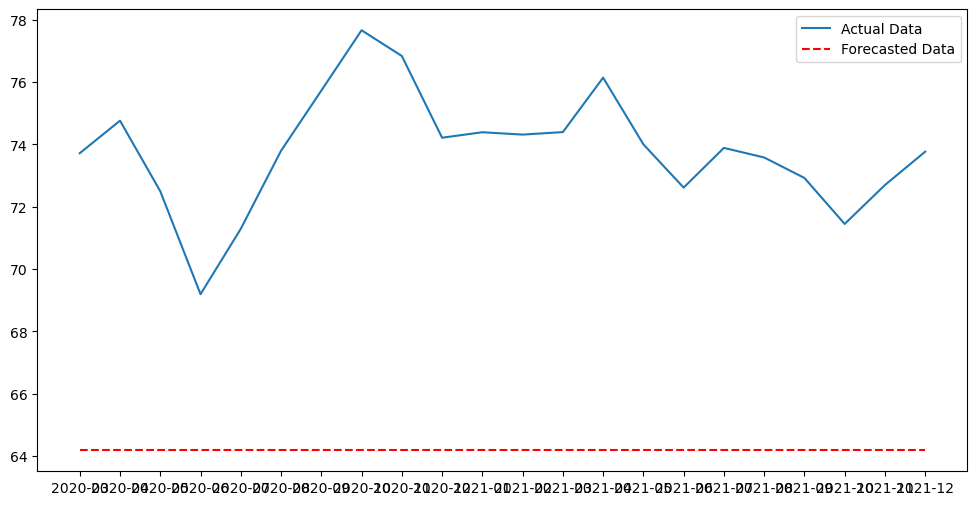

Test RMSE:  9.796859917864857
MAPE:  0.1298516238328759


In [71]:
plt.figure(figsize=(12,6))
#lt.plot(train, label='Training Data')
plt.plot(data_new['Курс'][50:], label='Actual Data')
plt.plot(forecast.mean, label='Forecasted Data', color='red', linestyle='--')
plt.legend()
plt.show()
print('Test RMSE: ', sqrt(mean_squared_error(data_new['Курс'][50:], forecast.mean)))
print('MAPE: ', mape(data_new['Курс'][50:], forecast.mean))

<Axes: xlabel='Дата'>

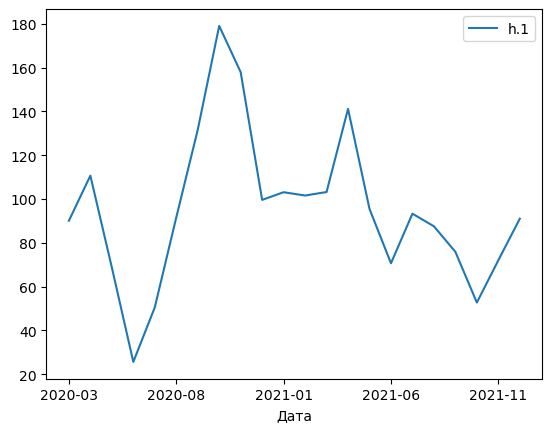

In [72]:
forecast.variance.plot()